In [1]:
import numpy as np
import pandas as pd
from os import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Select filename
fname_noext = 'SSL_Berkeley/xray_205_400_FTh_2mins'

# Select file extension
extension = 'txt'
fname = fname_noext + "." + extension

# Select module number
mod_number = 0

# Excluded detectors
excludeDetectors = []

# Excluded channels
excludeChannels = []

In [3]:
# Selection of the active channels for the common mode noise determination
# Change the variables excludeDetectors and excludeChannels to provide the
# channels to be removed from the calculation, if all channels are to be
# used set the two variables to [].
# Numbering is from detector #0 (ch. #0 to ch. #7) to detector #3 (ch. #24
# to ch. #31)

global chMask

Mask = np.ones((32,1),dtype='int')

for exclude in excludeDetectors:
    for i in range(8):
        Mask[exclude*8+i] = 0
for exclude in excludeChannels:
    Mask[exclude] = 0

chMask = (Mask > 0).nonzero()[0]
print('Common Mode Noise active channels are: {}'.format(chMask))

Common Mode Noise active channels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [4]:
# Function used to determine the pedestals. It uses only the events where
# all signals are below thr. The algorithm calculates the pedestals channel
# by channel by removing iteratively the channels that fall outside the
# range -nsigma*sigma_i < mean_i < nsigma*sigma_i. nsigma has a default
# value of 3.0.
# The function returns the pedestals (mean) and the standard deviation of
# the values selected to determine the pedestals (std)

def Pedestals(ev, thr, nsigma=3.):
    sel = np.ones(ev.shape,dtype='int')
    for i in range(32):
        sel[:,i] *= (ev[:,i] <= thr[i])
    std = np.zeros_like(ev[0,:])
    mean = np.zeros_like(std)
    for i in range(32):
        idx = (sel[:,i] > 0).nonzero()[0]
        v = ev[idx,i]
        mean[i] = v.mean()
        stdprev = v.std()
        idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
        mean[i] = v[idx].mean()
        std[i] = v[idx].std()
        while (std[i] < stdprev):
            stdprev = std[i]
            idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
            mean[i] = v[idx].mean()
            std[i] = v[idx].std()
    return [mean, std]

In [5]:
# Function used to determine the common mode noise. It subtracts the pedestals
# from the ADC values and uses the same algorithm of the Pedestal function,
# this time event by event, to select the channels without signal.
# The function returns the common mode channel selection matrix (ch), the number
# of common mode channels on each event (chn), the raw common mode noise (mean),
# and the event standard devation of the common mode channels (std) that can be
# used to select events where the common mode can be calculated correctly (those
# with low std).

def CMNchannels(ev, peds, nsigma=3.):
    global chMask
    v = ev-peds
    v = v[:,chMask]
    ch = np.zeros_like(v)
    stdprev = v.std(axis=1).reshape(v.shape[0],1)
    std = np.zeros_like(stdprev)
    mean = v.mean(axis=1)
    chn = np.zeros_like(std)
    for i in range(v.shape[0]):
        vv = v[i,:]
        chmax = (vv == vv.max()).nonzero()[0]
        chidx = np.array(range(v.shape[1]))
        chidx = np.delete(chidx,chmax)
        stdprev[i] = vv[chidx].std()
        mean[i] = vv[chidx].mean()
        chidx = (np.abs(vv-mean[i]) < nsigma*stdprev[i])
        idx = chidx.nonzero()[0]
        mean[i] = vv[idx].mean()
        std[i] = vv[idx].std()
        while (std[i] < stdprev[i]):
            stdprev[i] = std[i]
            chidx = (vv-mean[i] < nsigma*stdprev[i])
            idx = chidx.nonzero()[0]
            mean[i] = vv[idx].mean()
            std[i] = vv[idx].std()
        ch[i,:] = chidx[:]
        chn[i] = len(idx)
    return [ch, chn, mean, std]

In [6]:
# Function used by the minimization to determine the common mode noise coupling
# to thee various channels (common mode noise "gain"). It uses global variables
# containing the pedestal subtracted event data and the common mode noise selection
# matrix.

def cmnGain(p):
    global cmnEv
    global cmnCh
    n = cmnEv.shape[0]
    g = np.array(p)
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = ((cmnEv*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    y = (((cmnEv-cmn_matrix)*cmnCh)**2).sum()
    return y

In [7]:
# Function used to remove the common mode noise from the event data. It uses
# the raw event data, the pedestals, the common mode channels selection matrix
# and the common mode noise coupling gains. The function returns the pedestal
# and common mode corrected event data (v) and the event common mode noise (cmn).
# Note: the common mode noise is removed only for the active channels

def removeDisturbances(ev, peds, ch, g):
    global chMask
    v = ev-peds
    vv = v[:,chMask]
    n = vv.shape[0]
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*ch).sum(axis=1)).reshape(n,1)
    cmn = ((vv*ch).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    vv = vv-cmn_matrix
    for i,j in enumerate(chMask):
        v[:,j] = vv[:,i]
    return [v, cmn]

In [8]:
# Function used to determine the pedestals (ch_mean) and the noise (ch_std)
# after the pedestals and the common mode noise has been subtracted from the
# event data. The new pedestals should all be "zero" (within the noise limits)
# and the new noise standard deviations should be equal or smaller than the
# one calculated at the beginning by the pedestals determination function.

def histParameters(energy, thr, nsigma = 3.):
    ch_std = np.zeros(32)
    ch_mean = np.zeros(32)
    for i in range(32):
        idx = (energy[:,i] < thr).nonzero()[0]
        data = energy[idx,i]
        old_std = data.std()
        ch_mean[i] = data.mean()
        idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
        ch_std[i] = data[idx].std()
        ch_mean[i] = data[idx].mean()
        while (ch_std[i] < old_std):
            old_std = ch_std[i]
            idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
            ch_std[i] = data[idx].std()
            ch_mean[i] = data[idx].mean()
    return [ch_mean, ch_std]

In [9]:
# Load the file. Notice that this is very slow, be patient!

try:
    ev, evtype, module, chtype, channel, adc = np.loadtxt(fname, dtype='int', comments='#', usecols=(0, 1, 2, 3, 4, 5), unpack=True)
    N = np.unique(ev)
except:
    pass

In [10]:
# Print the number of events in the file

print('Events in file: ', len(N))
Event = []

idx = (module == mod_number).nonzero()[0]  # REMEMBER TO UPDATE THE MODULE NUMBER !!!!!!!!!!!!!!
evn = ev[idx]
ch = channel[idx]
val = adc[idx]

evnw = evn.view()
chw = ch.view()
valw = val.view()

# Determine the good events and store them in the Event list along with the event
# number and the channel numbers. This step eliminates all 0 and all 2047 events
# and the events where there is S&H saturation (changing the neg_saturation and
# the pos_saturation values can be used to play with saturation)

selected = 0
all_neg_saturation = 0
all_pos_saturation = 0
some_neg_saturation = 0
some_pos_saturation = 0
neg_saturation = 40.
pos_saturation = 2020.
if (len(N)):
    for n in N:
        # check only 40 rows at a time
        if (len(evnw) > 40):
            idx = (evnw[0:40] == n).nonzero()[0]
        else:
            idx = (evnw == n).nonzero()[0]
        # verify that the event contains 32 rows and all channels are present
        if ((len(idx) == 32) and (ch[idx].sum() == 496)):
            # verify saturation
            if ((valw[idx] <= neg_saturation).all()):
                all_neg_saturation += 1
            elif ((valw[idx] <= neg_saturation).any()):
                some_neg_saturation += 1
            elif ((valw[idx] >= pos_saturation).all()):
                all_pos_saturation += 1
            elif ((valw[idx] >= pos_saturation).any()):
                some_pos_saturation += 1
            else:
                Nch = chw[idx]
                ADCs = valw[idx]
                Event.append([n, Nch, ADCs])
                selected += 1
        ii = len(idx)
        evnw = evnw[ii:].view()
        chw = chw[ii:].view()
        valw = valw[ii:].view()

# Plot the good/bad events statistics
print('Real events: ', selected+all_neg_saturation+some_neg_saturation+all_pos_saturation+some_pos_saturation)
print('All negative saturated: ', all_neg_saturation)
print('Some negative saturated: ', some_neg_saturation)
print('All positive saturated: ', all_pos_saturation)
print('some positive saturated: ', some_pos_saturation)
print('Selected: ', selected)

Events in file:  30379
Real events:  30379
All negative saturated:  0
Some negative saturated:  2
All positive saturated:  3
some positive saturated:  0
Selected:  30374


In [11]:
# Prepare the event and pedestal variables for the analysis

global events
global peds
n = len(Event)
peds = np.zeros((1, 32))
events = np.empty((n, 32))
for i, data in enumerate(Event):
    events[i,:] = data[2]

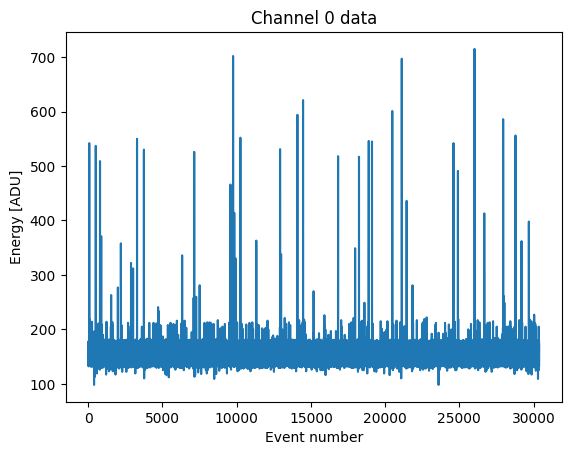

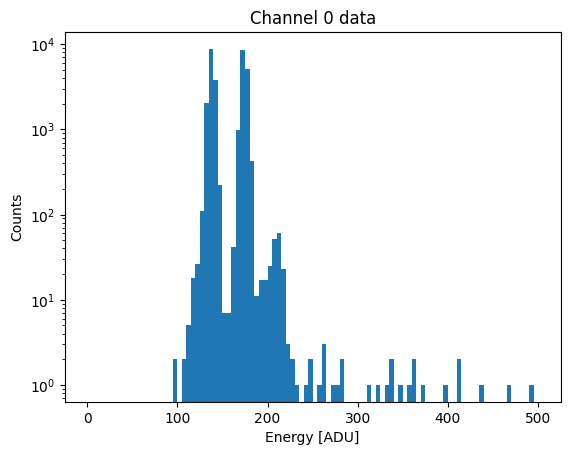

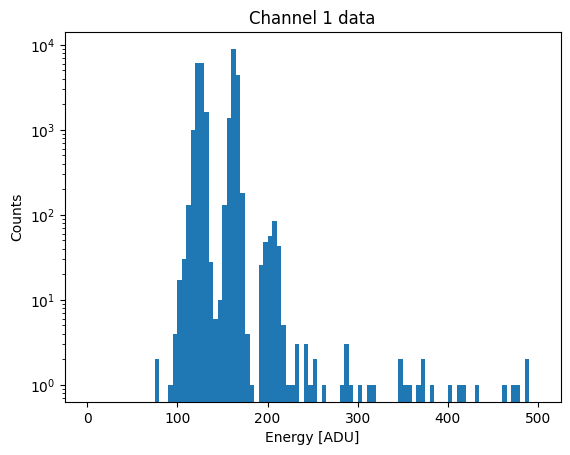

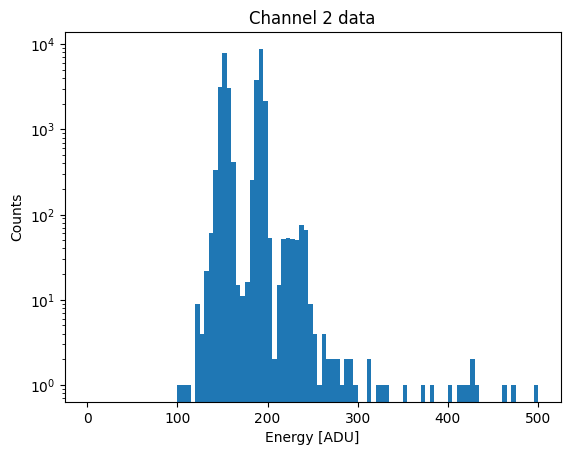

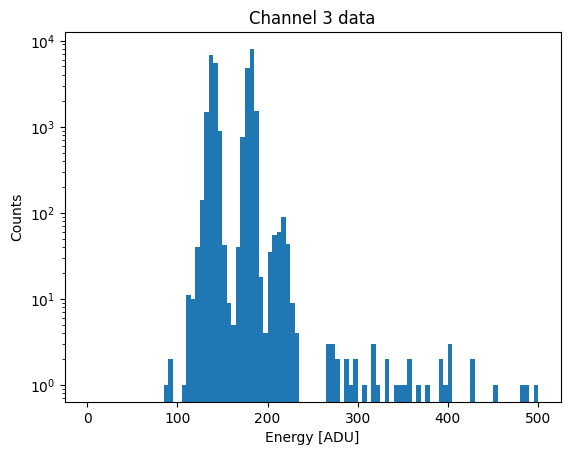

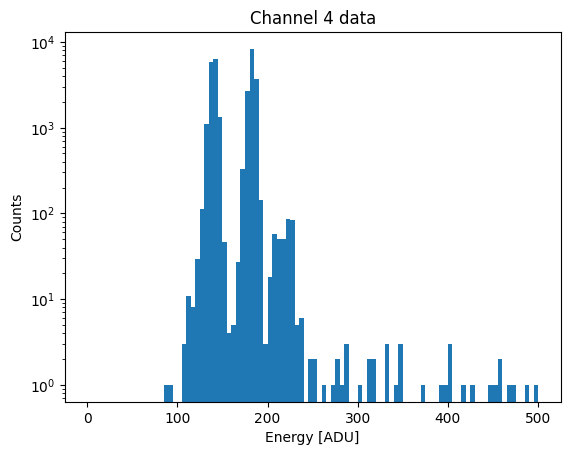

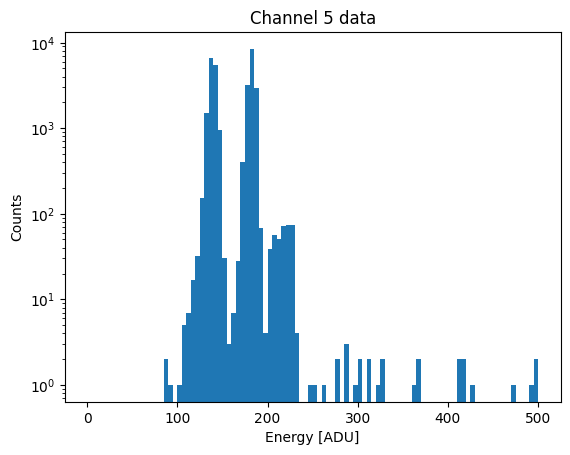

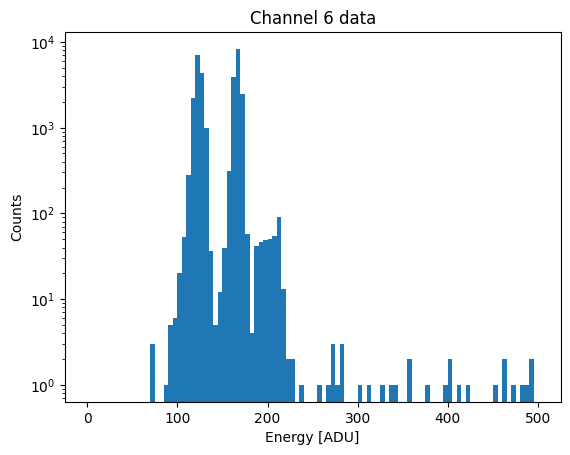

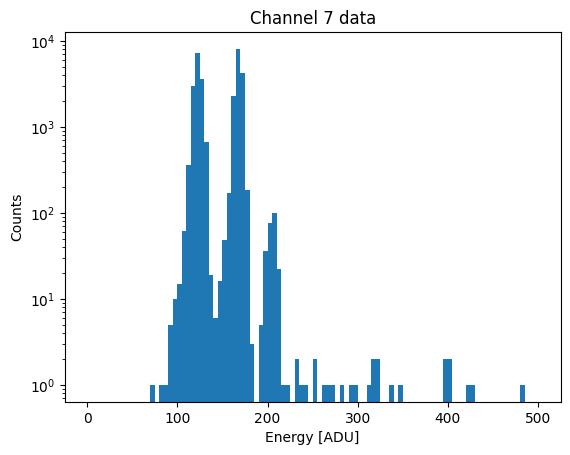

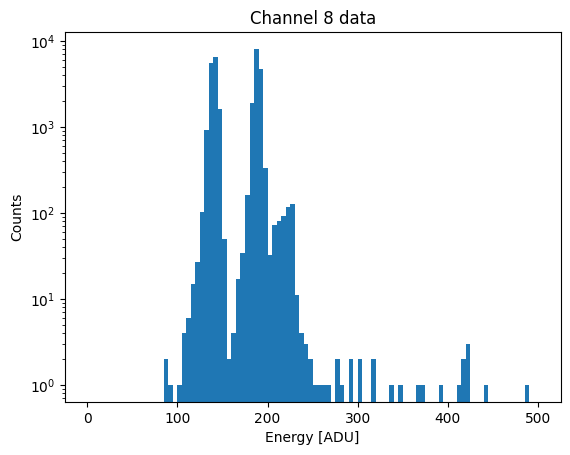

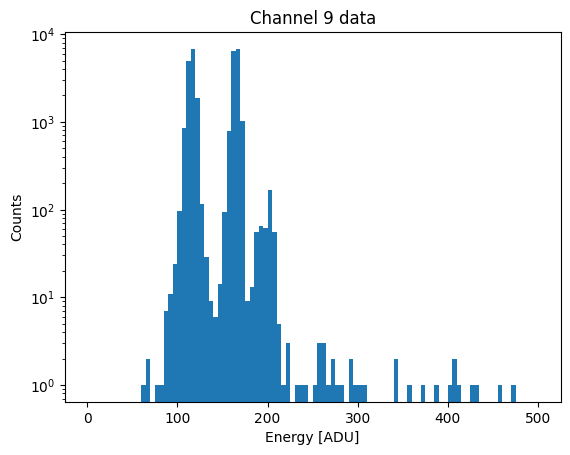

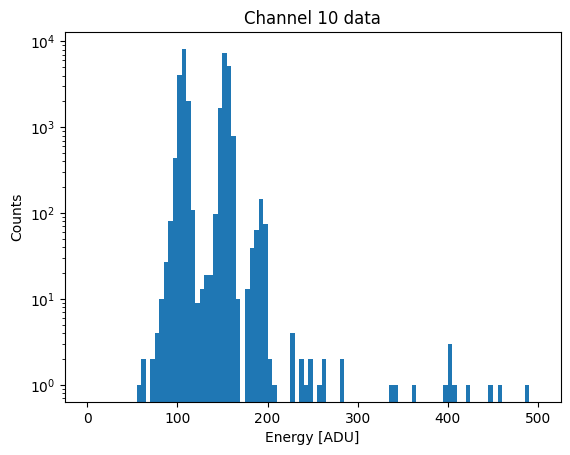

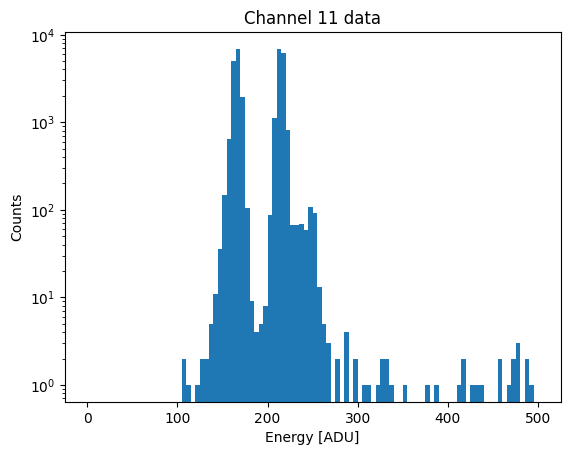

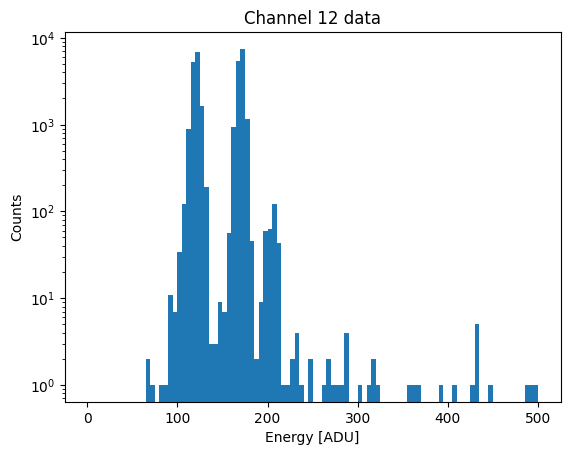

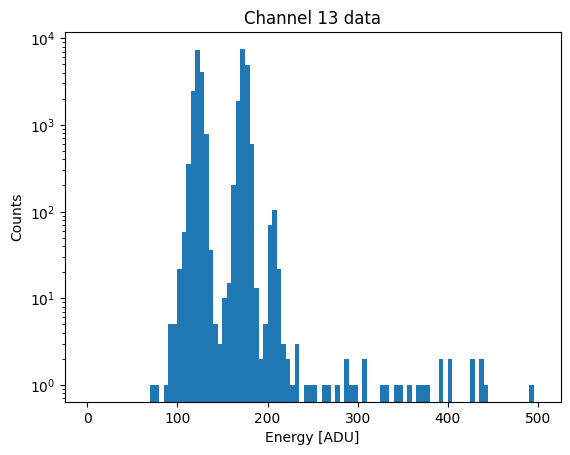

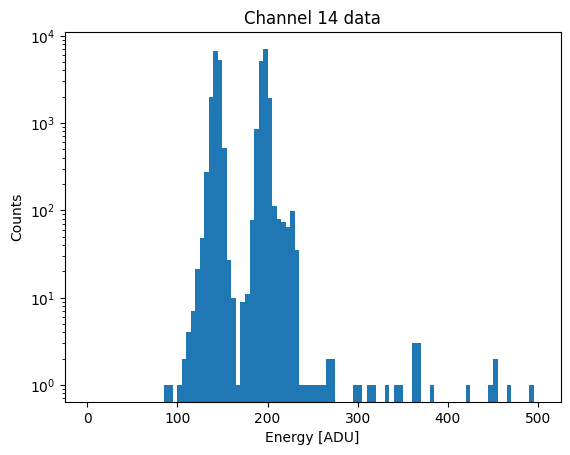

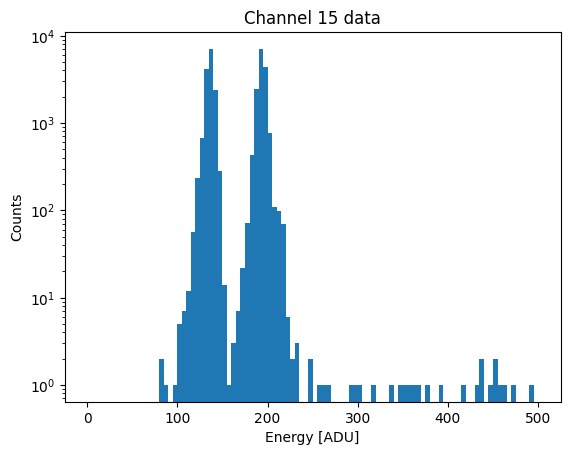

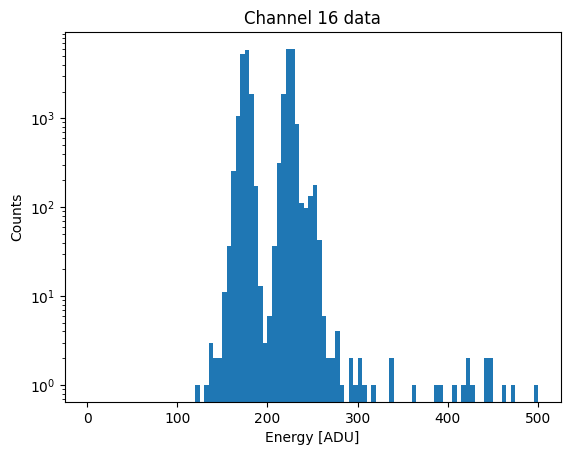

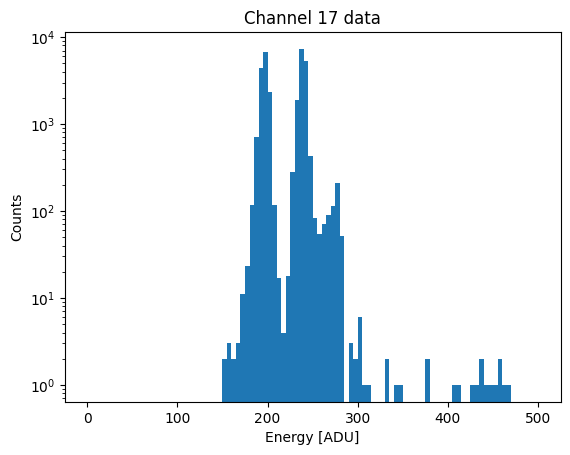

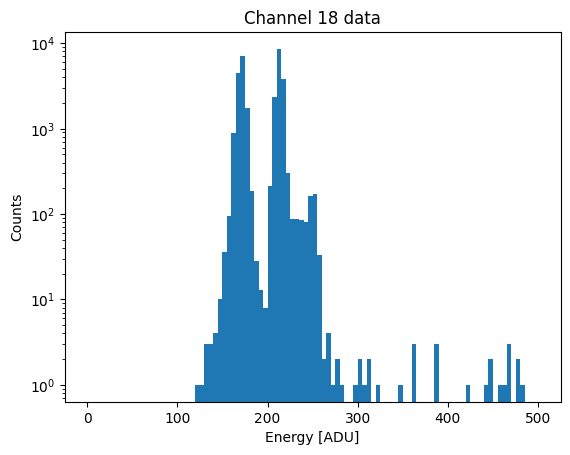

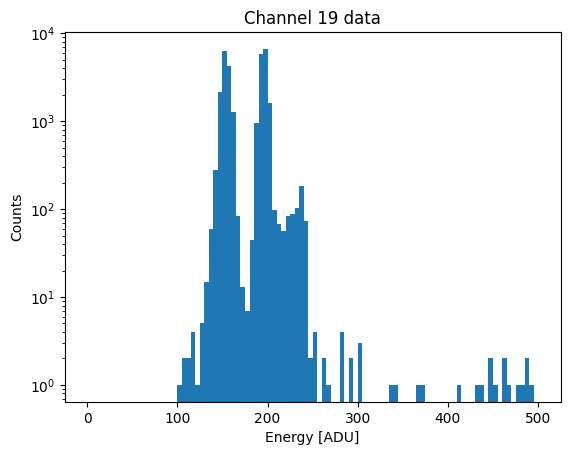

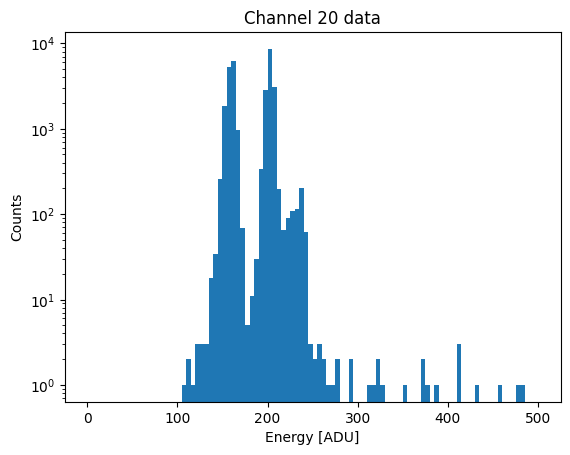

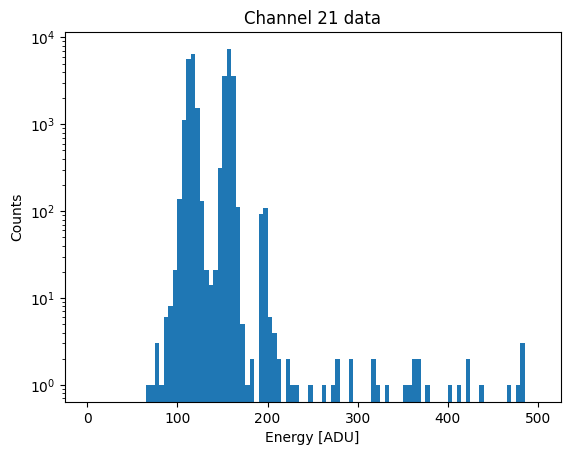

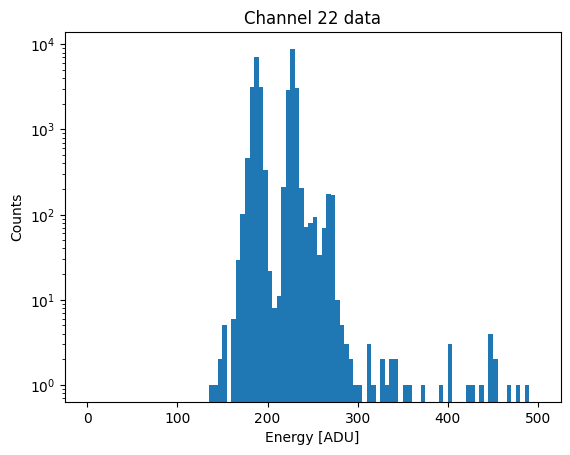

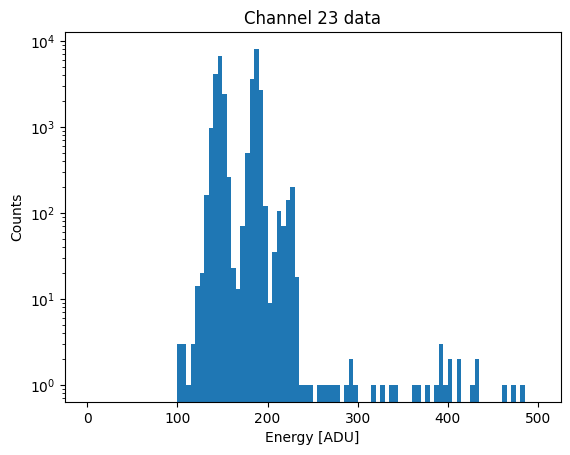

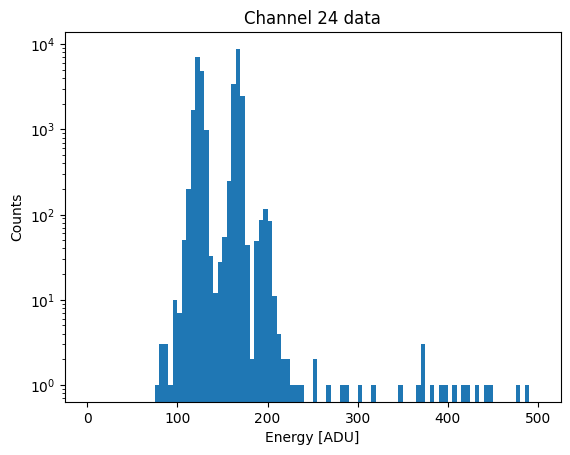

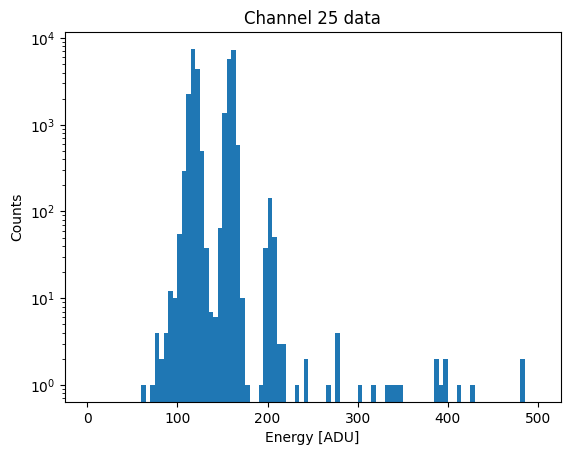

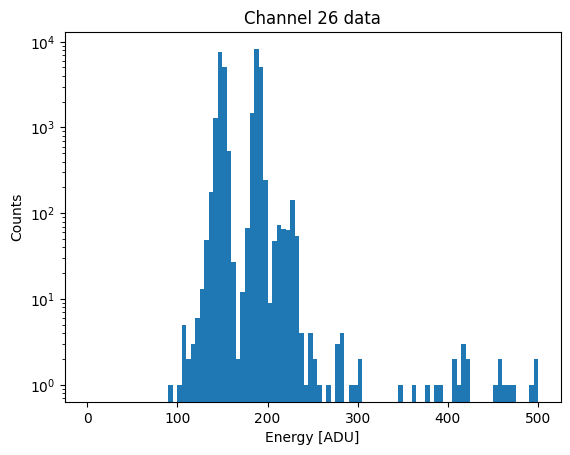

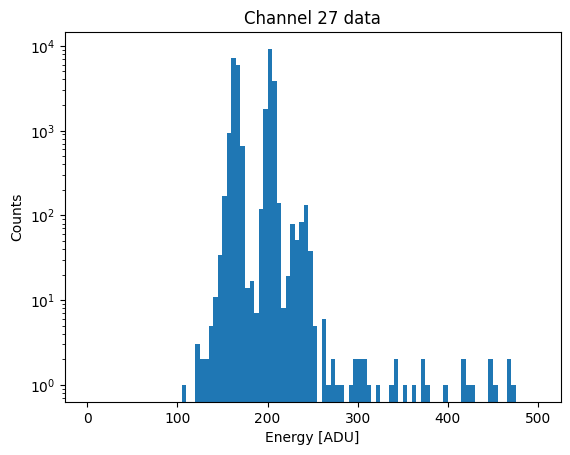

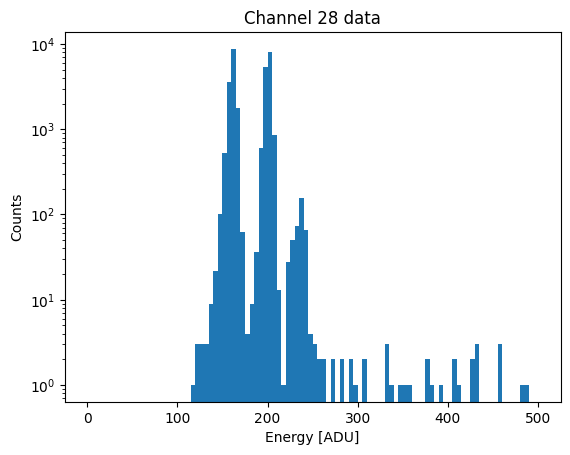

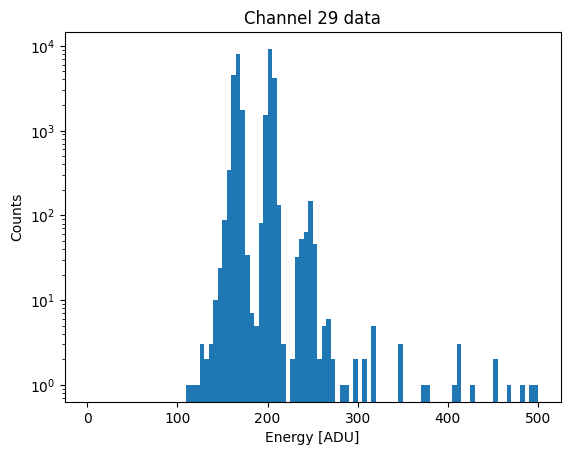

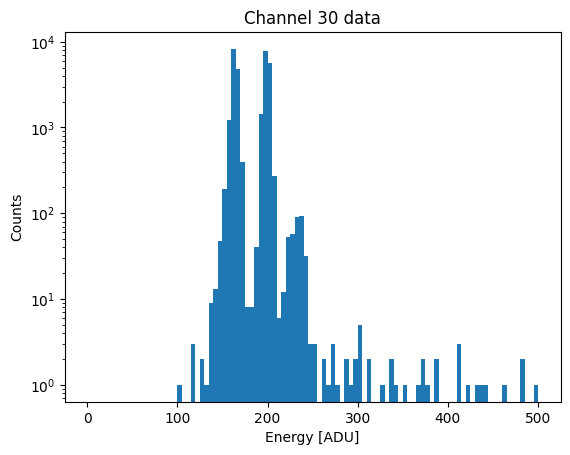

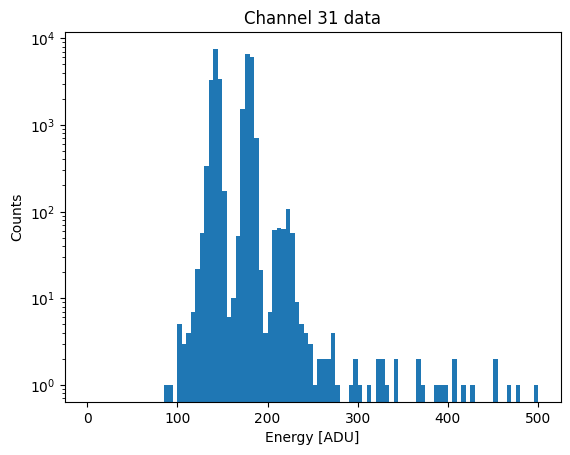

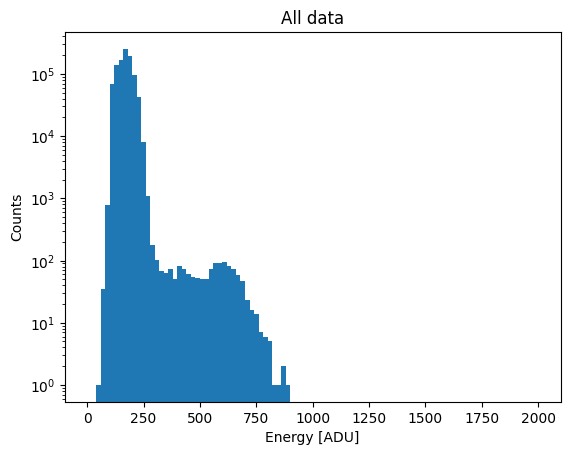

Channel averages:
 [156.53177059 144.78554026 173.0015803  160.79647067 162.27948245
 161.60489234 145.92822809 146.01254362 165.60601172 141.4956871
 131.02479094 191.49690525 146.23865806 148.97685521 170.63965892
 165.59109765 201.04948311 219.22963719 193.74395865 176.39089353
 182.15773359 136.73954698 209.53315335 167.9429117  145.9554224
 139.52564693 170.15263054 184.71923356 181.59771515 185.55228156
 182.08020017 161.91331402] 



In [12]:
# Plot raw data histograms channel by channel (also the sequential data aquisitions
# for channel 0) and all together

i = 0
plt.plot(events[:,i])
plt.title('Channel {} data'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
#plt.axis([0,200,0,200])
plt.show()
for i in range(32):
    plt.hist(events[:,i],100,(0,500))
    plt.semilogy()
    plt.title('Channel {} data'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.show()

plt.hist(events.flatten(),100,(0,2000))
plt.semilogy()
plt.title('All data'.format(i))
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
#plt.axis([0,200,0,200])
plt.show()

# Print the average values for all channels
print('Channel averages:\n', events.mean(axis=0), '\n')

In [13]:
# Determine the pedestals and print them along with their standard deviation and the
# difference between pedestals and channel mean value (this one just for sport)

# thr = [2047] * 32

# Load pedestal file to determine channel threshold
ped_data = pd.read_csv("SSL_Berkeley\Pedestals.dat", sep = "\t")
ped_data_pt5 = ped_data[ped_data["pt"]==5]
ped_mean = ped_data_pt5["mean"]

thr = ped_data_pt5["mean"].to_numpy()
thr = [thri + 10 for thri in thr]

peds, s = Pedestals(events, thr, 2.)
print('Pedestals:\n', peds, '\n')
print('Sigmas:\n', s, '\n')
print('Pedestals - Channel averages:\n', peds-events.mean(axis=0))

Pedestals:
 [138.01385575 124.60101311 152.21678214 139.0465728  139.95793918
 139.12461816 122.59461586 121.98506986 140.09243564 115.83712517
 106.0511277  165.4073654  120.40042165 122.4652819  143.52782778
 136.48649073 175.21264101 196.0563919  170.48012183 153.35161211
 158.99241907 115.08384523 186.9331761  145.98872658 123.03977831
 118.05324232 148.83037994 163.8842333  161.00097429 165.86256554
 163.17800606 141.908111  ] 

Sigmas:
 [2.13098706 2.88771062 2.64998935 2.55140502 2.58235279 2.59206199
 2.32297043 2.58921775 2.60544939 2.60155135 2.61027285 2.95154612
 2.80399746 2.33640726 2.9158448  2.8391627  3.16380213 2.61635287
 2.8614483  2.84758546 3.14999452 2.63584082 3.10504256 3.08712792
 2.06520374 2.66451312 2.62429173 2.25642839 2.56734209 2.59852364
 2.00621498 2.69079739] 

Pedestals - Channel averages:
 [-18.51791485 -20.18452715 -20.78479816 -21.74989787 -22.32154328
 -22.48027419 -23.33361223 -24.02747376 -25.51357608 -25.65856193
 -24.97366323 -26.08953985 -2

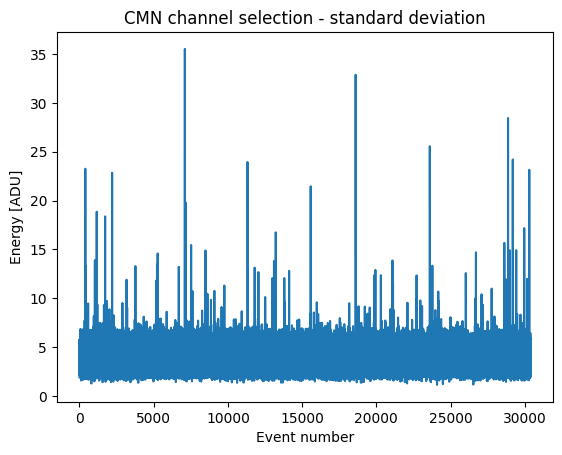

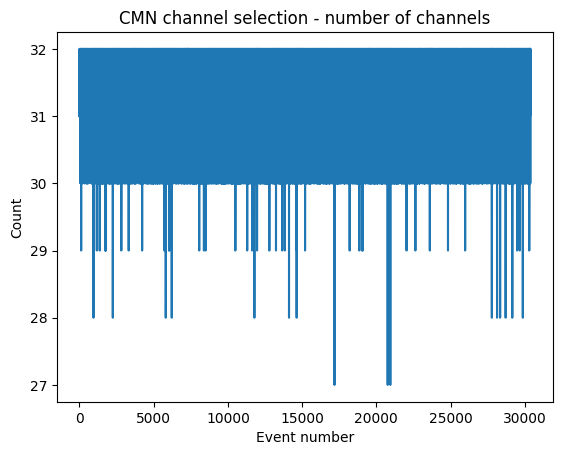

In [14]:
# Determine the common mode noise selection matrix and plot the standard deviation
# of the common mode channels and their number

ch, chn, CMNraw, std = CMNchannels(events,peds,3.)
plt.plot(std)
plt.title('CMN channel selection - standard deviation'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('CMN channel selection - number of channels'.format(i))
plt.xlabel('Event number')
plt.ylabel('Count')
plt.show()

In [15]:
## Determine the good events (common mode noise standard deviation lower than
# std_val) and print how many they are, prepare the global variables for the
# common mode gain determination step.

n = ch.shape[0]
std_val = 14.
idx = (std < std_val).nonzero()[0]
good = len(idx)
print('Number of good events (cmn std < {}): {}'.format(std_val, good))
global cmnEv
global cmnCh
cmnEv = events[idx,:]-peds
cmnEv = cmnEv[:,chMask]
cmnCh = ch[idx,:]

Number of good events (cmn std < 14.0): 30352


In [16]:
# Find the common mode noise coupling to the channels (common mode noise gain).
# p are the parameters of the minimization (the gains). This is also slow...

p = np.ones((1,len(chMask)), dtype=float)

result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})

# alternative minimization method with bounds
#bnds = np.ones((len(chMask),2), dtype=float)
#bnds[:,0] = 0.8
#bnds[:,1] = 1.2
#result = minimize(cmnGain, p, method='SLSQP', bounds=(bnds), options={'maxiter': 1e3, 'disp': True})

C:\Users\ghisl\AppData\Local\Temp\ipykernel_21240\2235674991.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})


Optimization terminated successfully.
         Current function value: 6507572.588529
         Iterations: 2129
         Function evaluations: 3427


Common mode gains:
 [0.8303904  0.88965768 0.91314119 0.9591656  0.97941726 0.98647683
 1.01437064 1.05903306 1.11421114 1.13010126 1.1067918  1.13539638
 1.14971464 1.18089325 1.20414324 1.27871637 1.12758346 0.9812569
 0.97899623 0.97064838 0.99635912 0.9681737  0.93425136 0.9401878
 1.00640806 0.95266297 0.91833517 0.89899688 0.90419065 0.85719829
 0.82009637 0.86072693] 

Sum of gains:  32.04769300546761


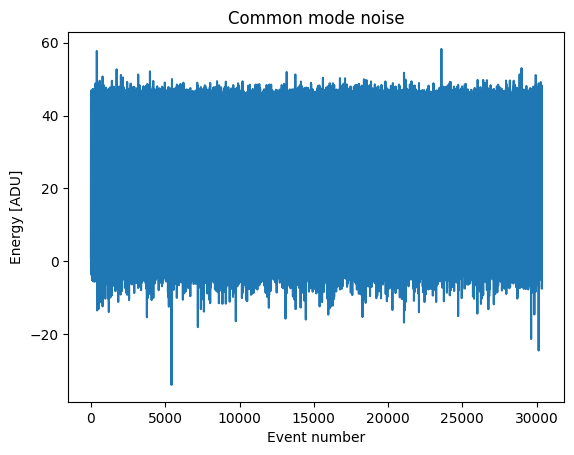

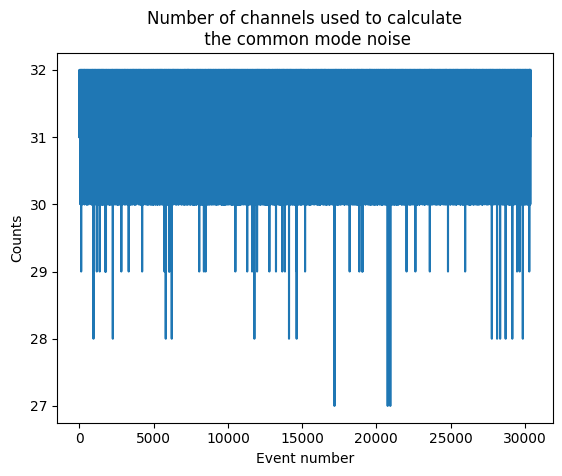

In [17]:
# remove the common mode noise (disturbances) from the event data, print the
# common mode noise gains, and plot the common mode noise along with the number
# of channels used to calculate it. The output is the variable Energy containing
# the pedestal and common mode noise subtracted event data for the good events
# (good as defined above)

g = result.x
print('Common mode gains:\n', g, '\n')
print('Sum of gains: ', g.sum())
idx = (std < std_val).nonzero()[0]
ev_good = events[idx,:]
ch_good = ch[idx,:]
energy, cmn = removeDisturbances(ev_good, peds, ch_good, g)
plt.plot(cmn)
plt.title('Common mode noise')
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('Number of channels used to calculate\n the common mode noise'.format(i))
plt.xlabel('Event number')
plt.ylabel('Counts')
plt.show()

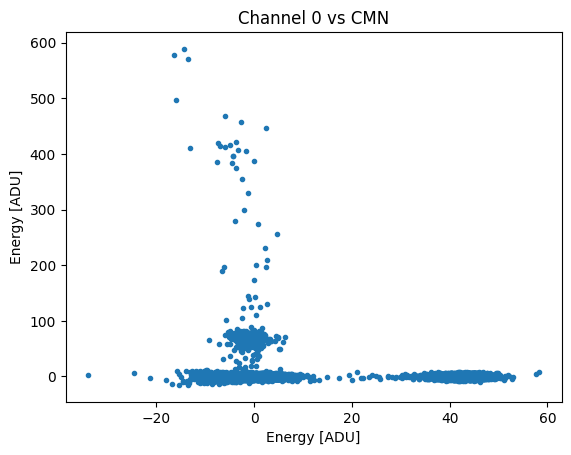

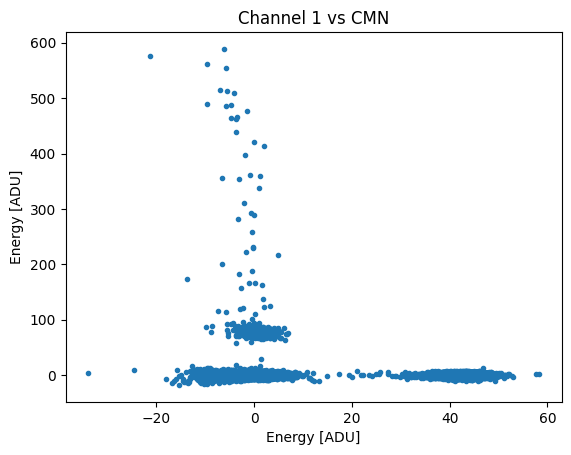

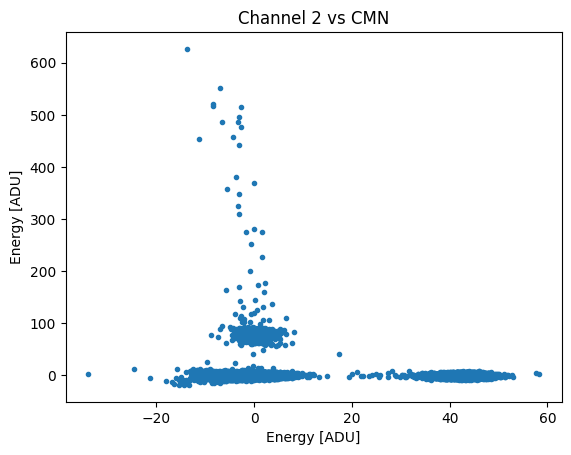

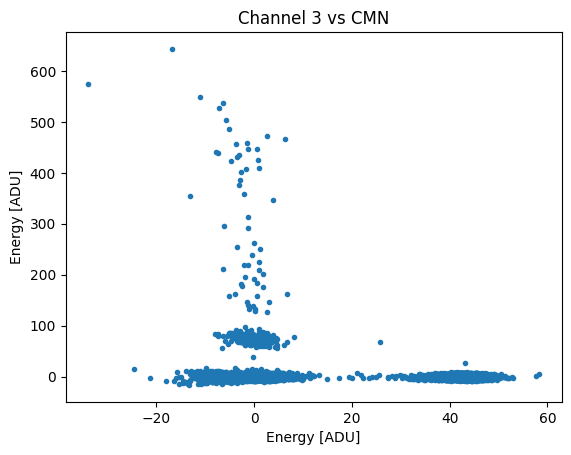

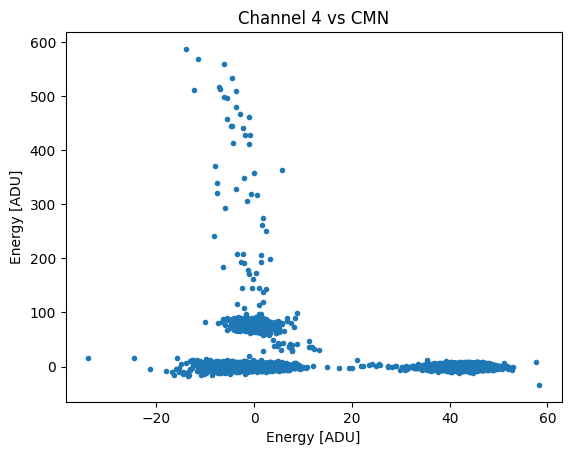

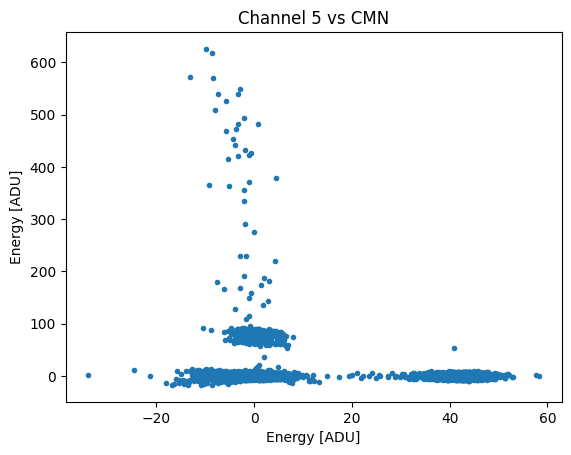

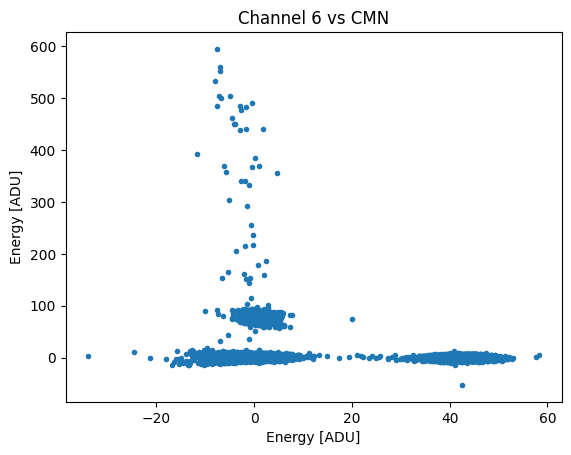

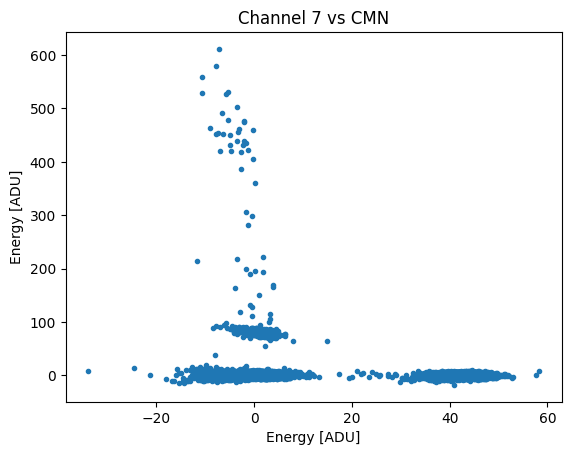

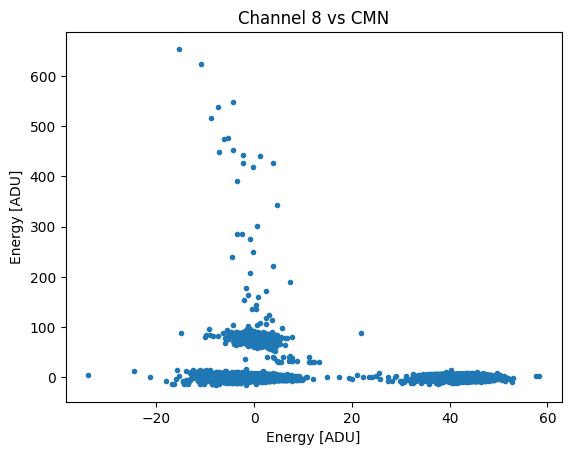

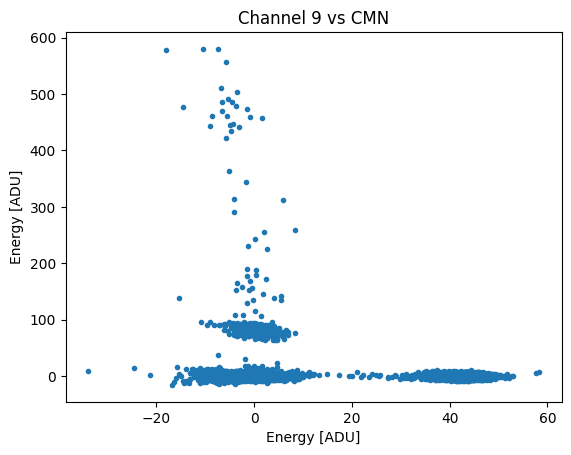

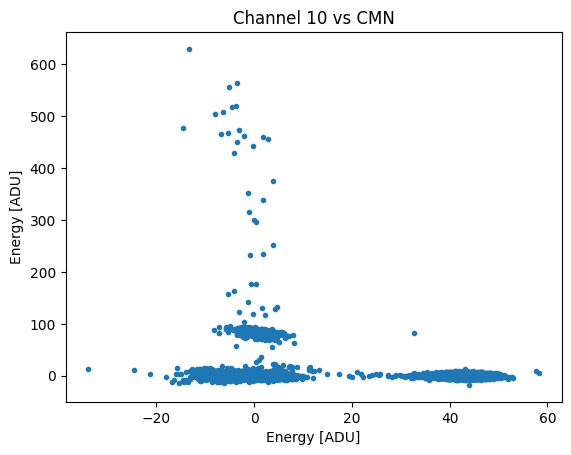

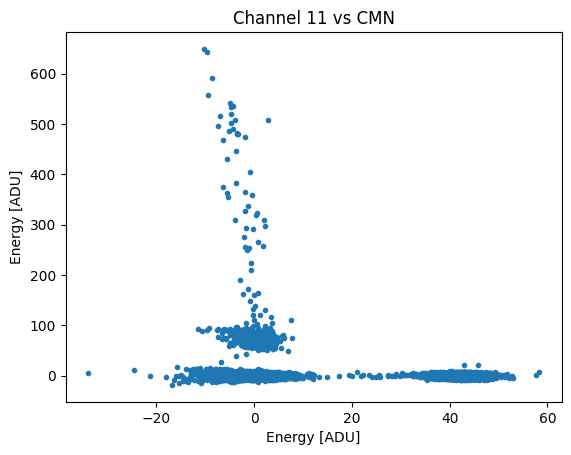

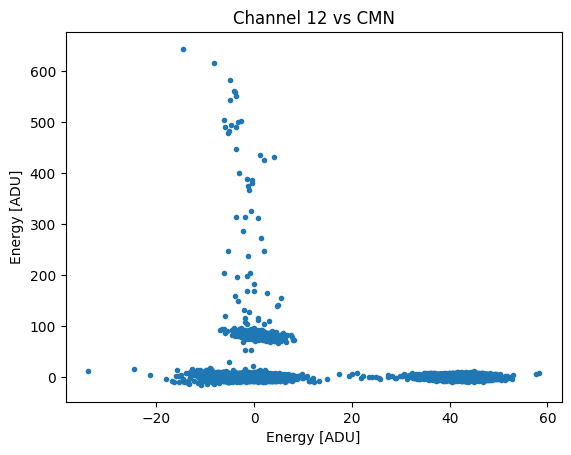

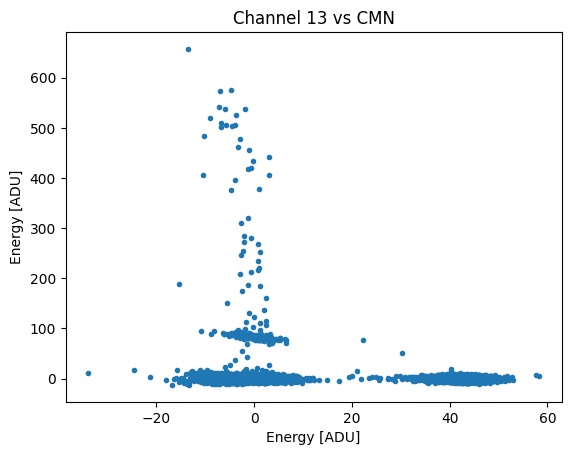

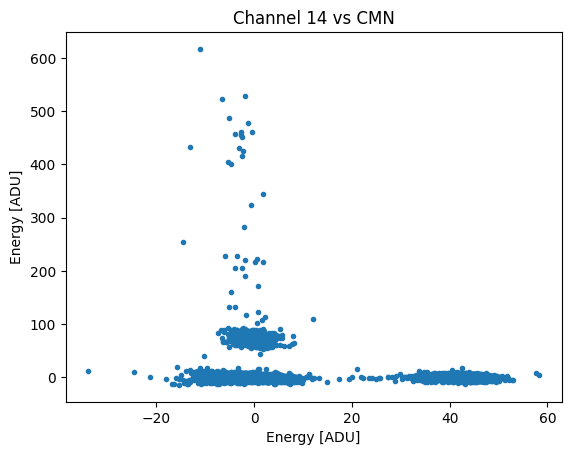

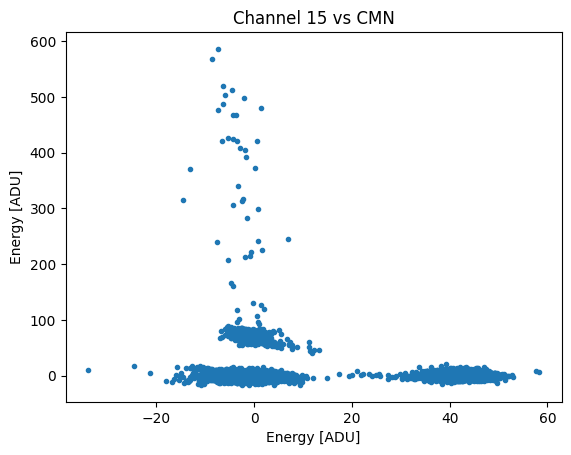

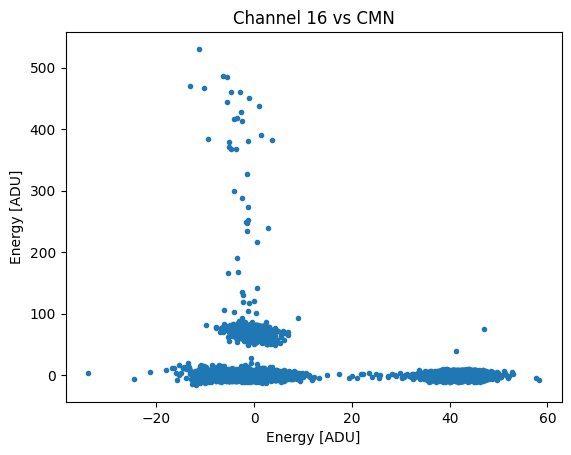

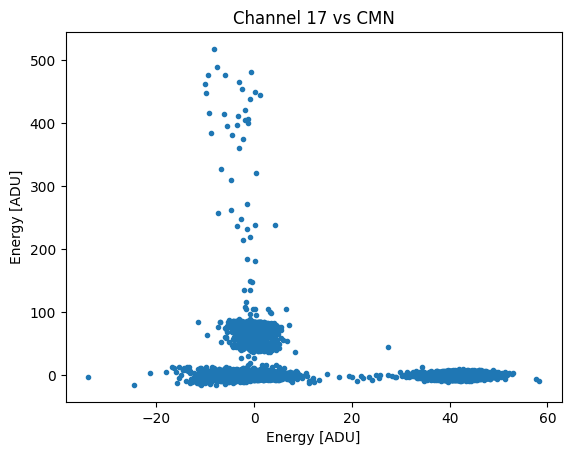

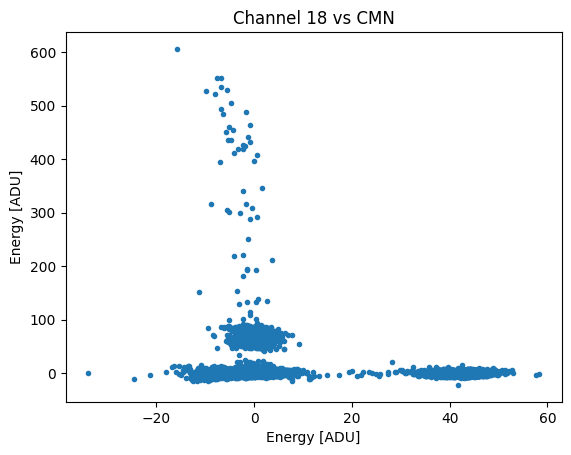

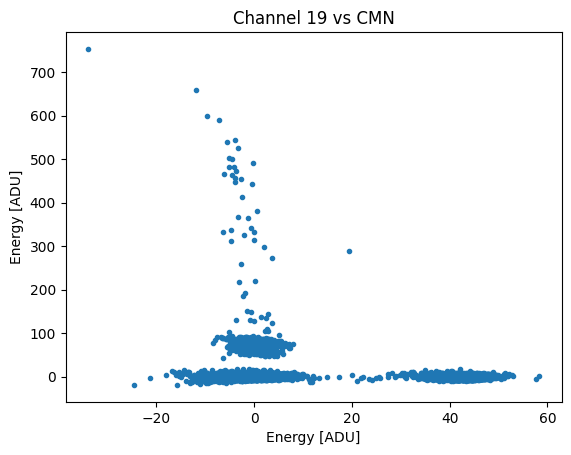

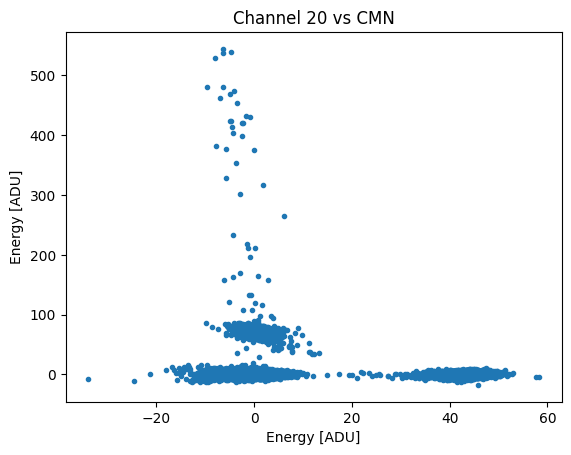

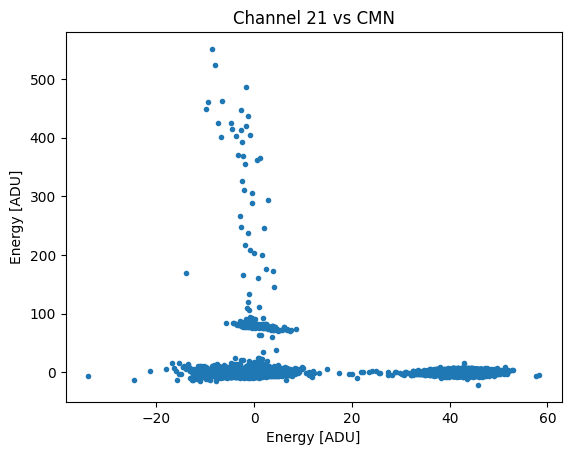

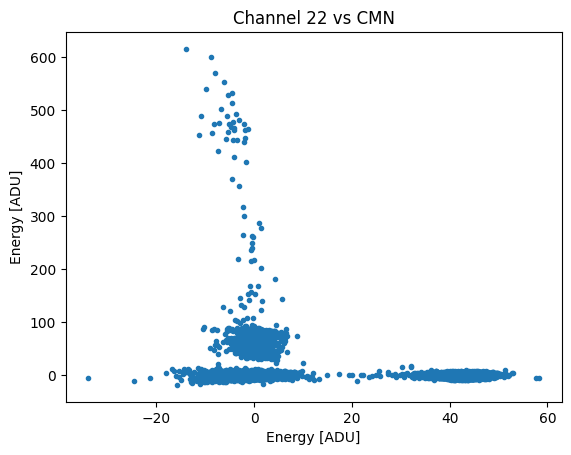

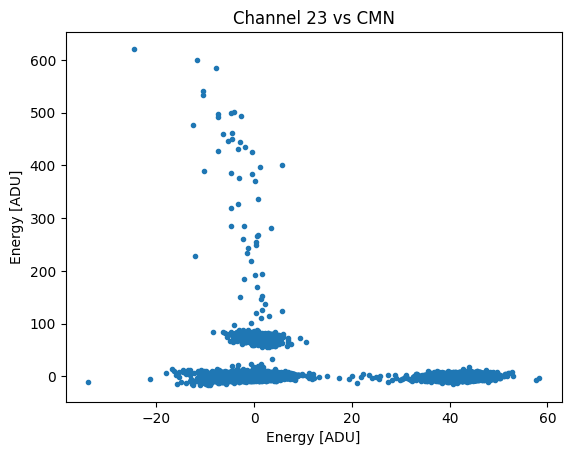

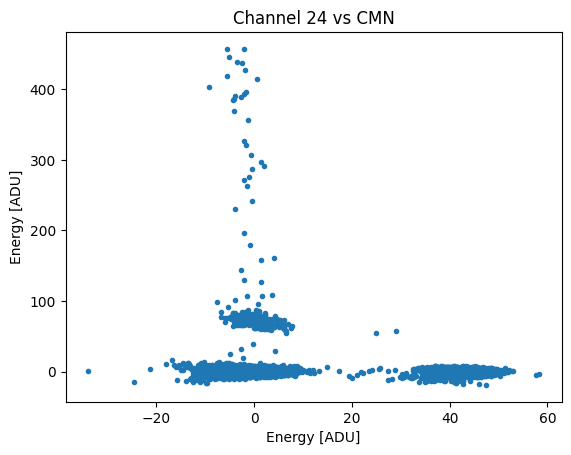

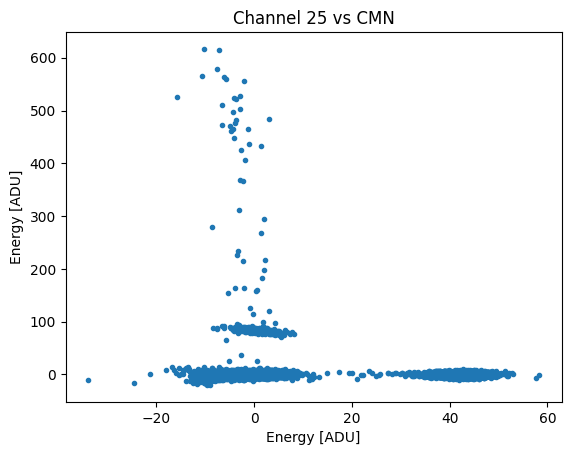

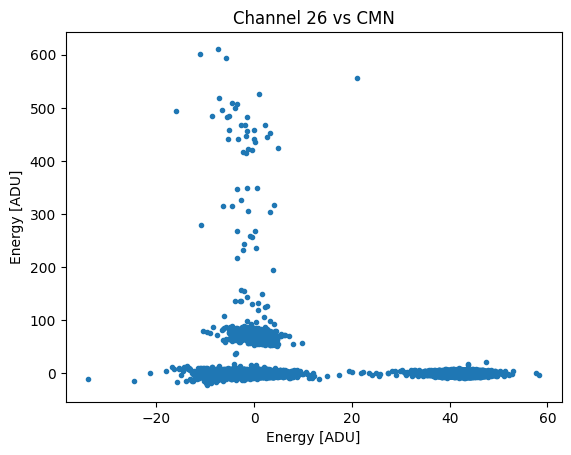

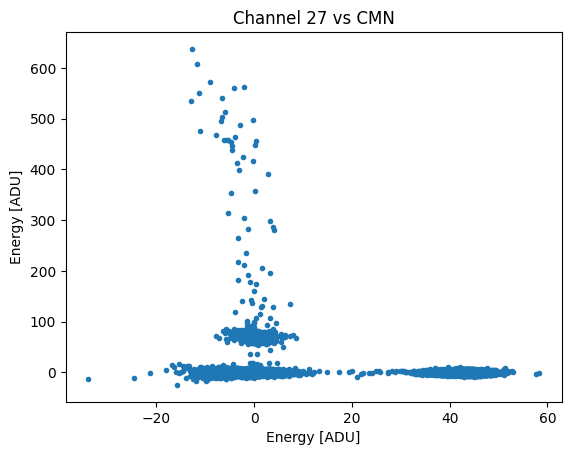

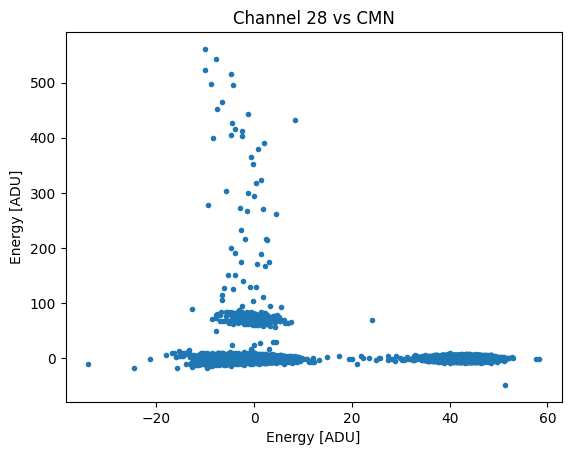

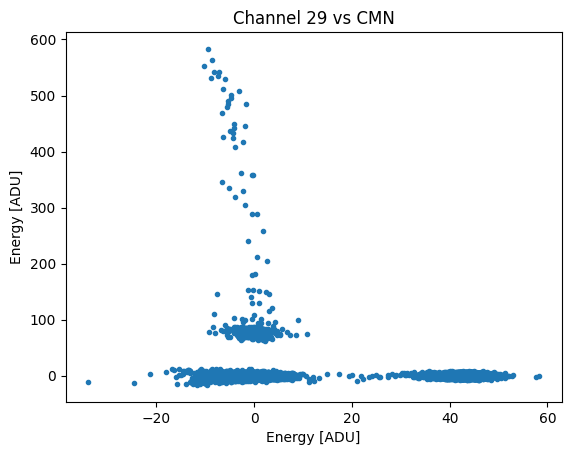

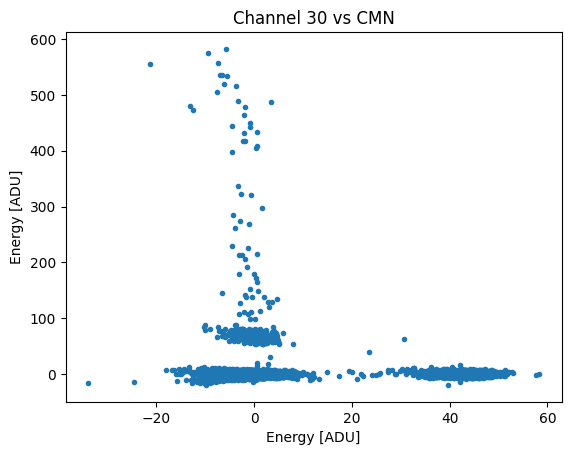

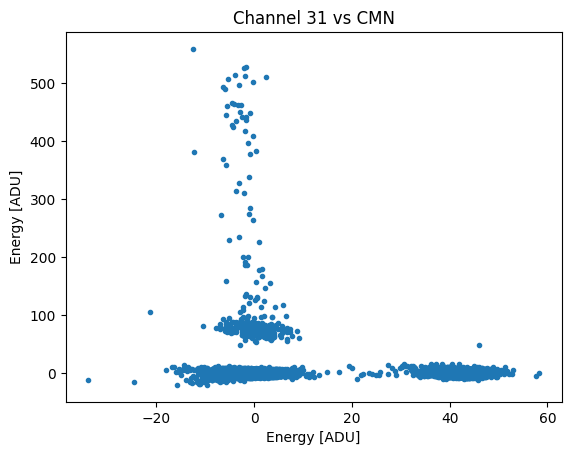

In [18]:
# Show correlation plots of the Energy data with respect to the common mode noise

for i in range(32):
    plt.plot(cmn, energy[:,i],'.')
    plt.title('Channel {} vs CMN'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Energy [ADU]')
    plt.show()

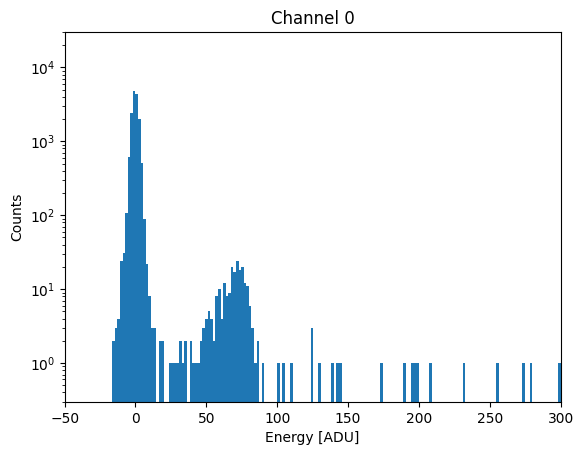

Saved ch 0


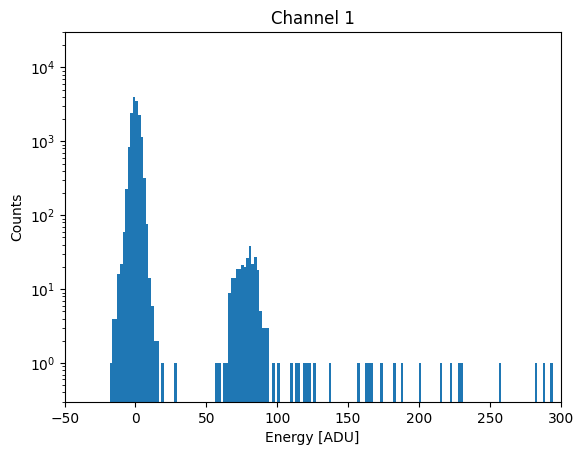

Saved ch 1


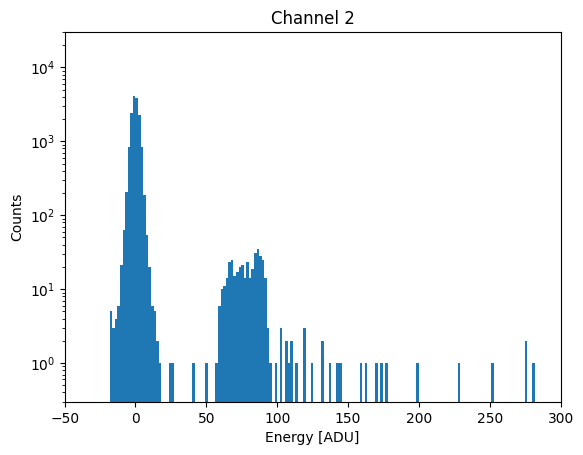

Saved ch 2


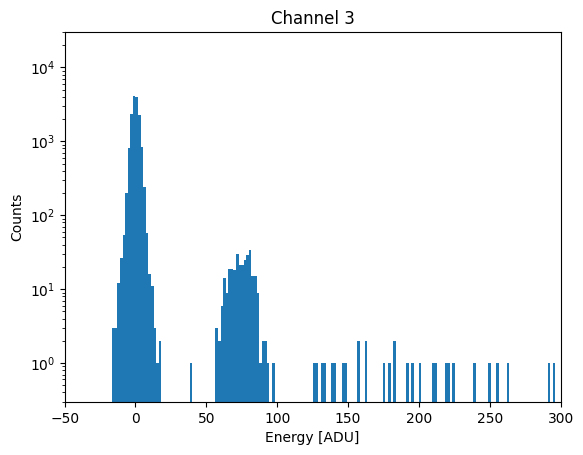

Saved ch 3


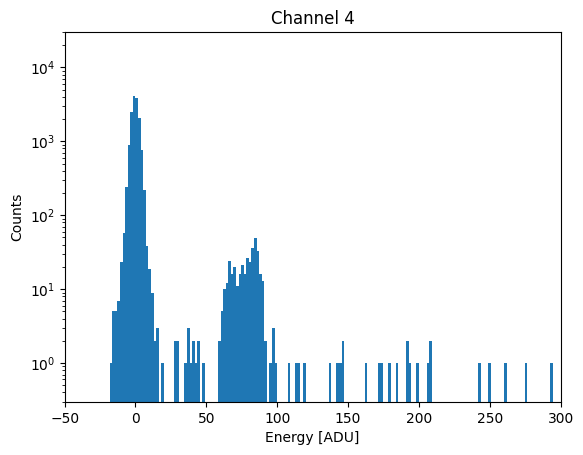

Saved ch 4


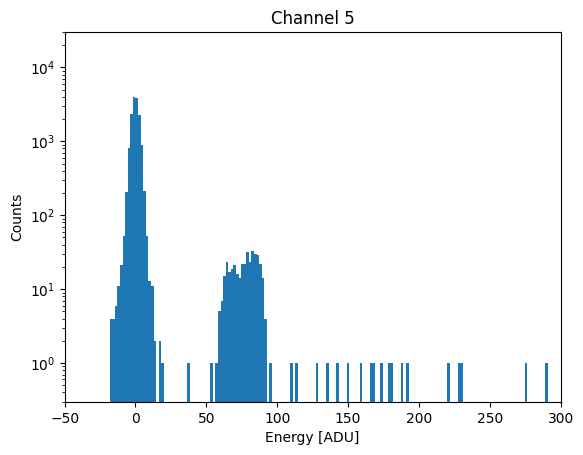

Saved ch 5


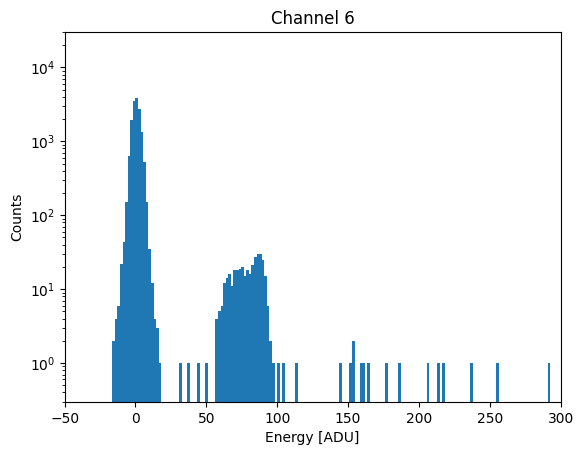

Saved ch 6


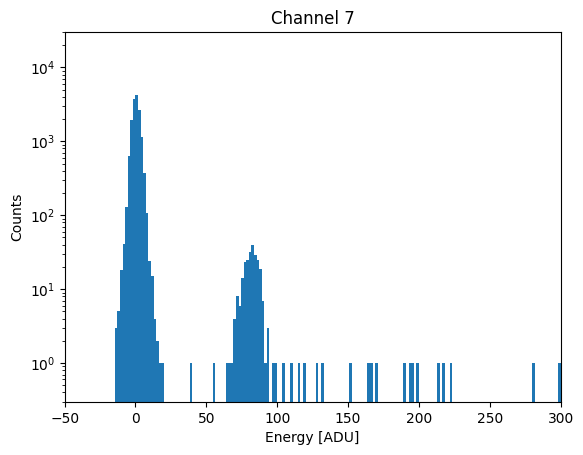

Saved ch 7


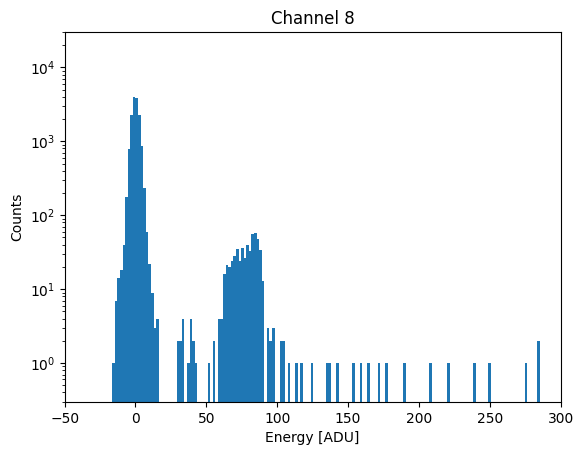

Saved ch 8


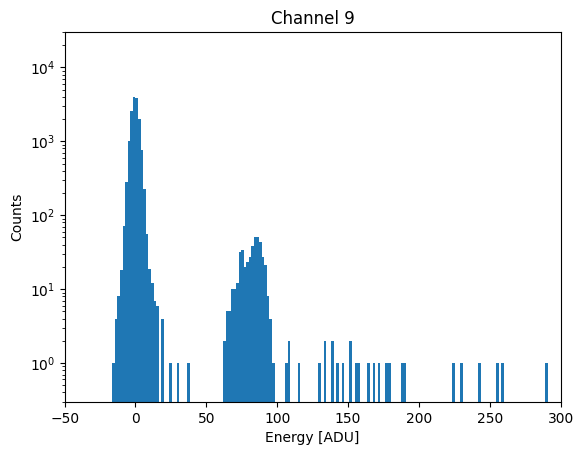

Saved ch 9


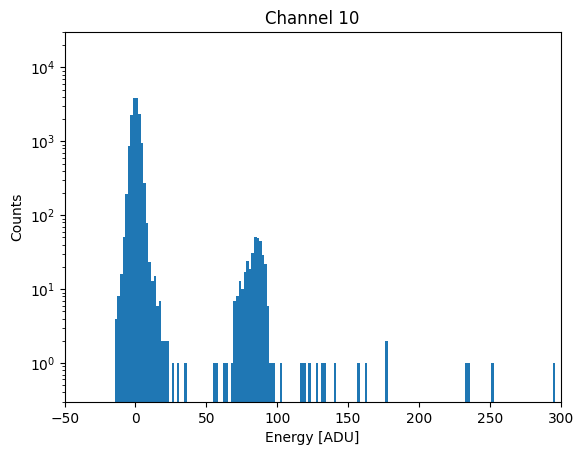

Saved ch 10


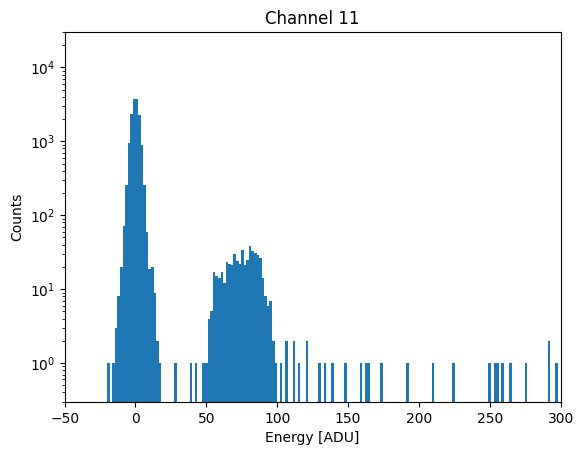

Saved ch 11


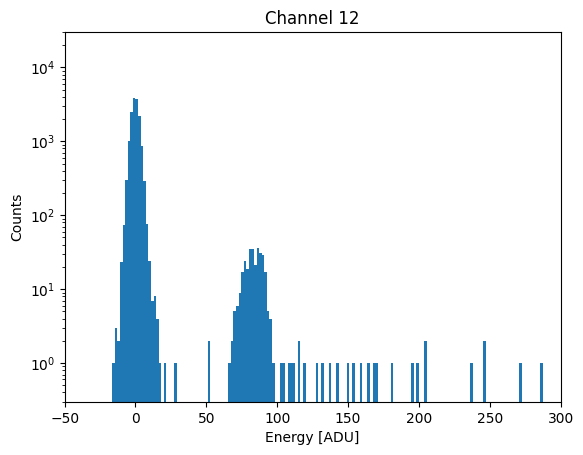

Saved ch 12


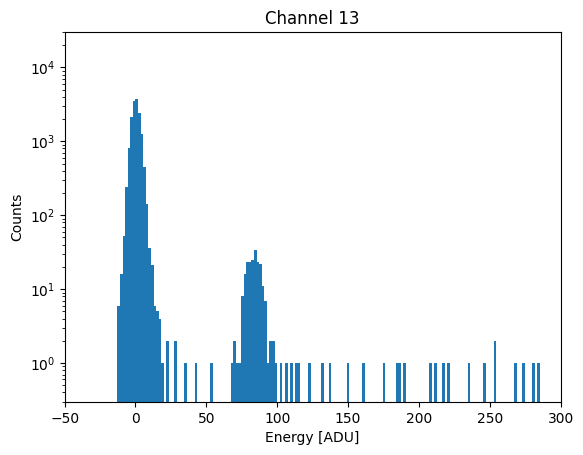

Saved ch 13


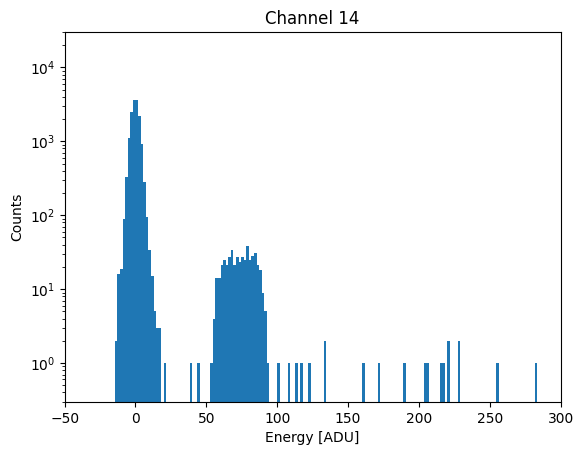

Saved ch 14


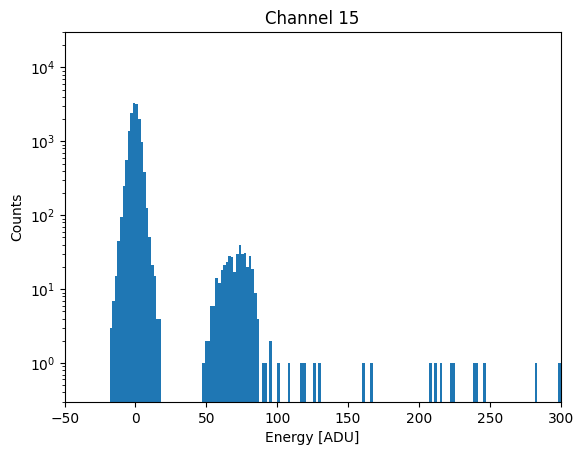

Saved ch 15


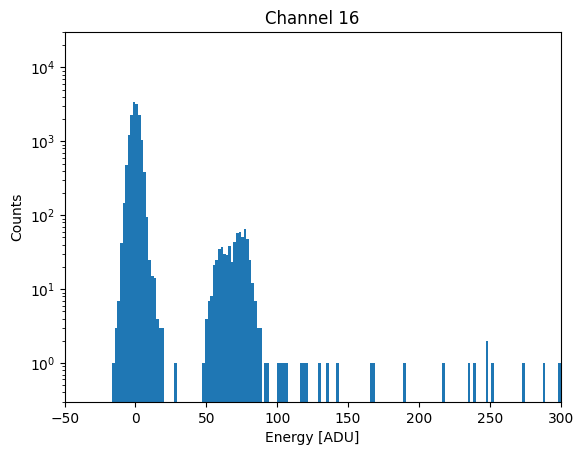

Saved ch 16


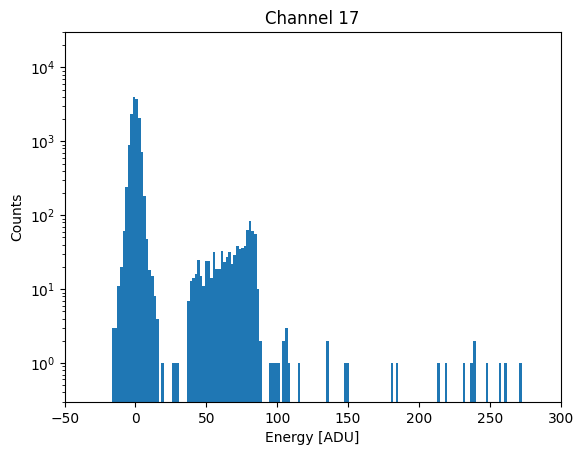

Saved ch 17


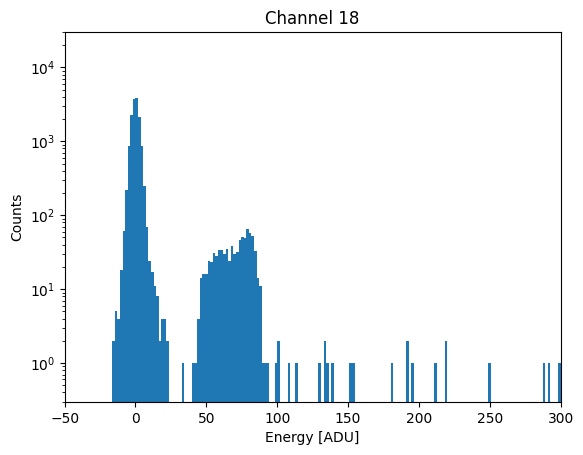

Saved ch 18


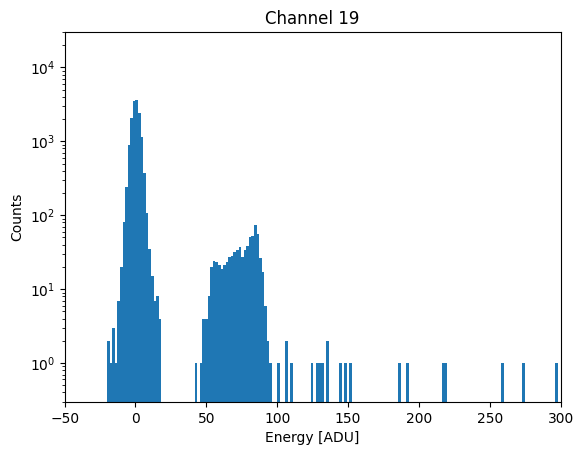

Saved ch 19


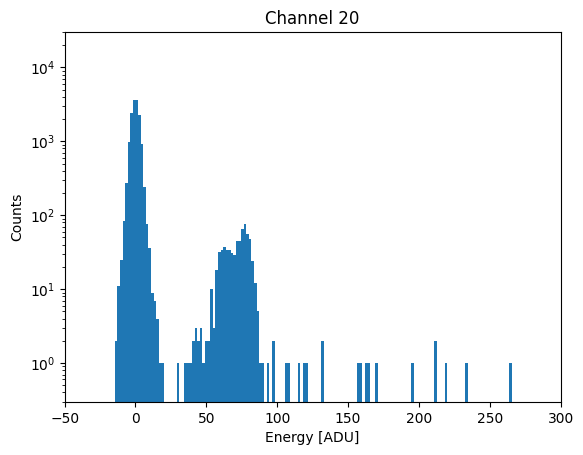

Saved ch 20


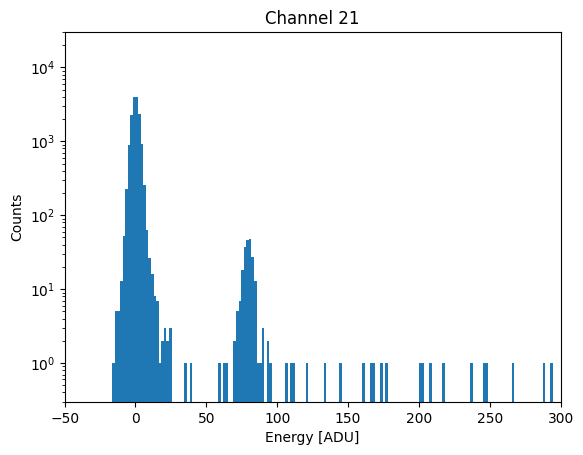

Saved ch 21


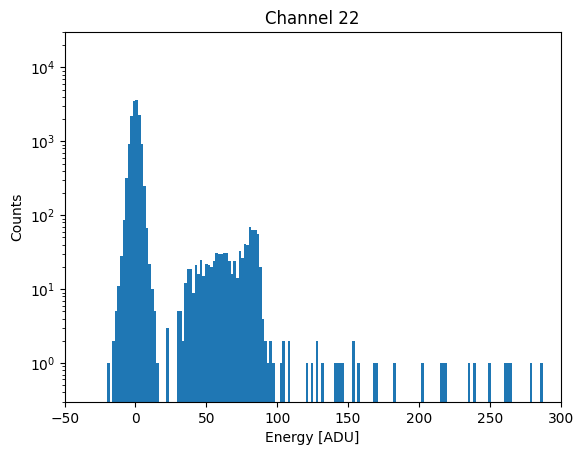

Saved ch 22


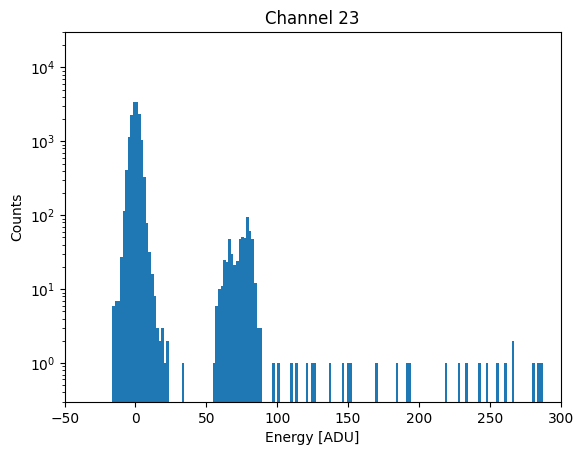

Saved ch 23


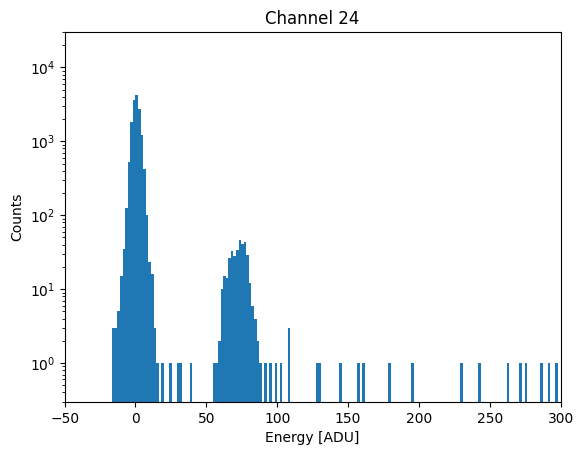

Saved ch 24


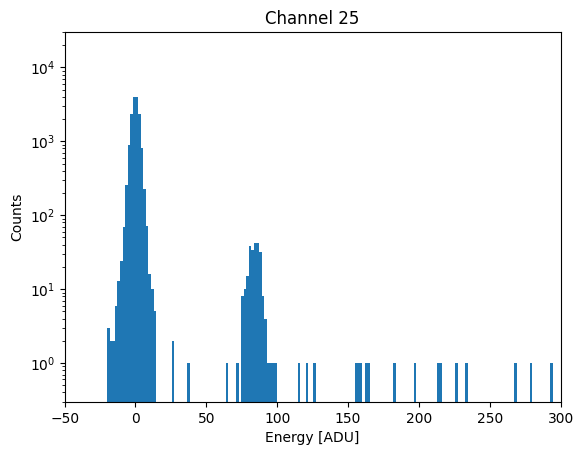

Saved ch 25


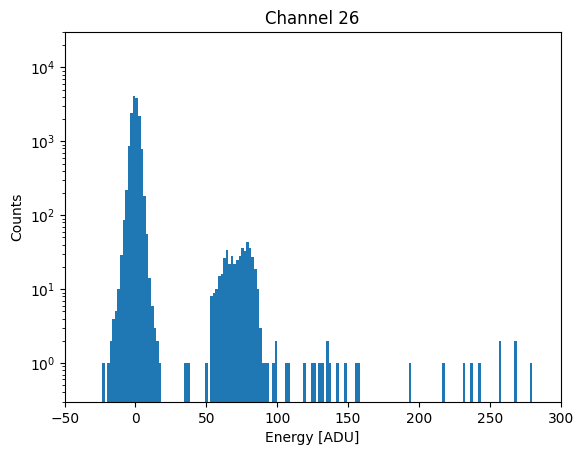

Saved ch 26


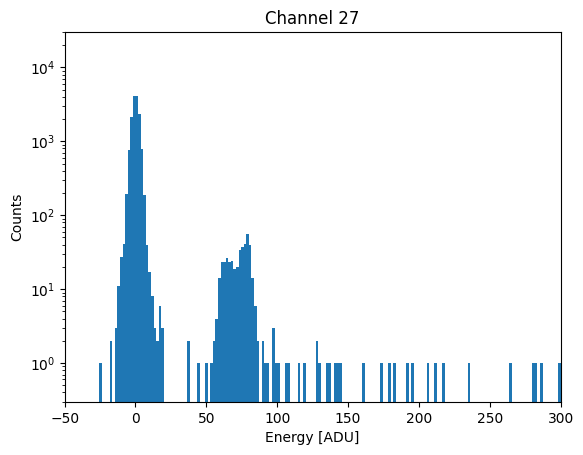

Saved ch 27


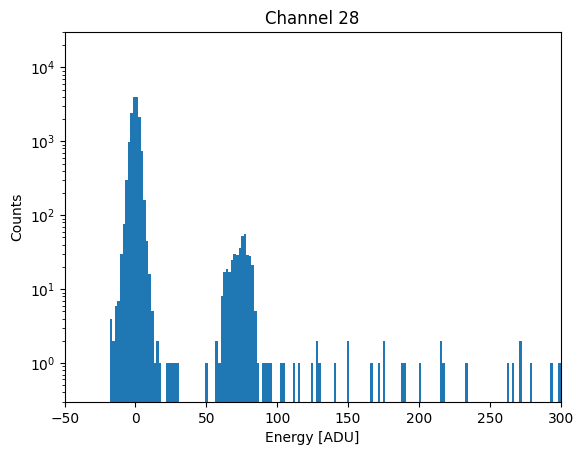

Saved ch 28


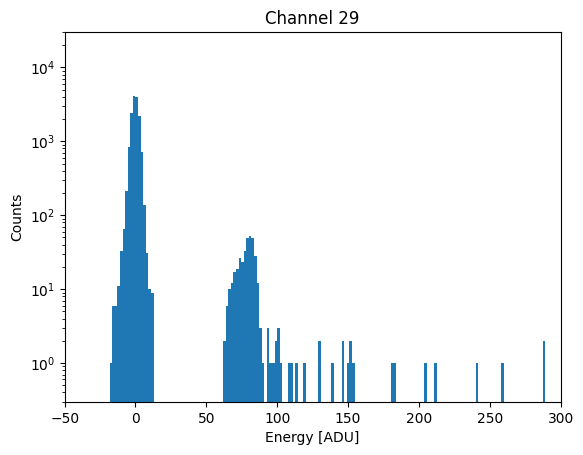

Saved ch 29


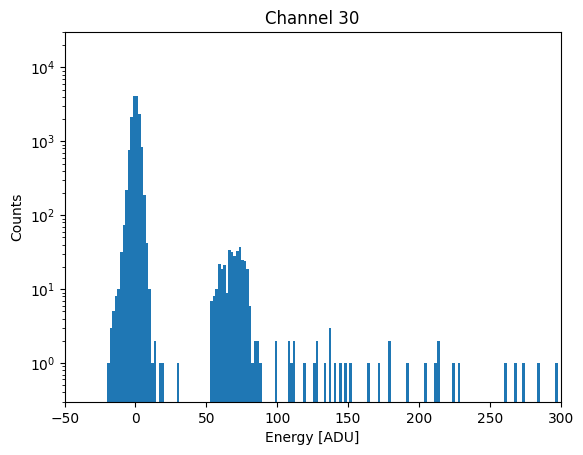

Saved ch 30


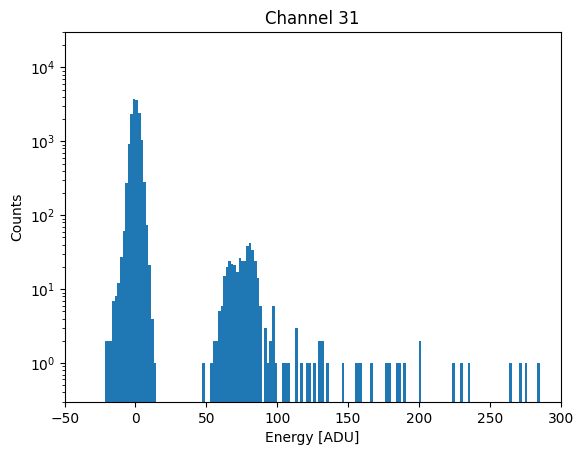

Saved ch 31


<Figure size 640x480 with 0 Axes>

In [25]:
# Plot the Energy histogram for all channels. These histograms should have a
# pedestal peak and the MIP signal (if present)

if not path.exists(fname_noext):
    mkdir(fname_noext)
    
pdf_path = path.join(fname_noext, "pdf")
    
if not path.exists(pdf_path):
    mkdir(pdf_path)
                   
png_path = path.join(fname_noext, "png")
    
if not path.exists(png_path):
    mkdir(png_path)
    
csv_path = path.join(fname_noext, "csv")
    
if not path.exists(csv_path):
    mkdir(csv_path)

for i in range(32):
    idx = (cmn < 10).nonzero()[0] # select the events where the signal is present
    plt.hist(energy[idx,i],220,(-100,300))
    plt.semilogy()
    plt.title('Channel {}'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.axis([-50, 300, 0.3, 30000])
    
    plt.savefig(path.join(pdf_path, "ch" + str(i) + ".pdf")) 
    plt.savefig(path.join(png_path, "ch" + str(i) + ".png")) 
    
    plt.show()
    plt.clf() 

    my_df = pd.DataFrame(energy[idx, i])
    my_df.to_csv(path.join(csv_path, "ch" + str(i) + ".csv"), header = False, index= False)
    
    print("Saved ch " + str(i))
   

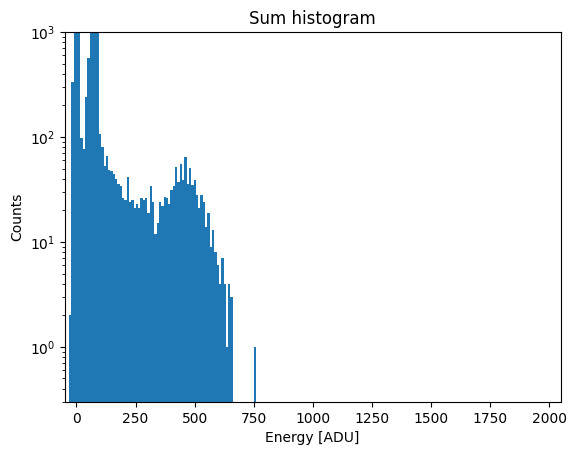

In [22]:
# Plot the sum histogram of the Energy of all active channels. Keep in mind that the channel
# gains are not equalized, this should be performed in a further step when every channel
# has a muon peak

energyActive = energy[idx,:]
energyActive = energyActive[:,chMask]
plt.hist((energyActive).flatten(),220,(-100,2047))
plt.semilogy()
plt.title('Sum histogram')
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
plt.axis([-50, 2047, 0.3, 1000])
plt.show()

In [23]:
# Determine the new pedestal and electronics noise of the channels after
# pedestal and common mode noise subtraction

pedestals, noise = histParameters(energy[idx,:], 50, nsigma = 3.)
print ('Histogram pedestals:\n', pedestals, '\n')
print ('Histogram standard deviations:\n', noise)

Histogram pedestals:
 [-0.1405432   0.08213181 -0.05239791  0.01114322 -0.14625922  0.01094694
  0.61048163  0.43668121  0.04726006 -0.21855129  0.07193482 -0.03681849
 -0.10442273  0.35889815 -0.13672415 -0.37659484 -0.15236575 -0.16798533
 -0.00527326  0.23574701 -0.06530041  0.01733768 -0.01151153 -0.07194188
  0.57814639 -0.05457835 -0.09082709  0.02993291 -0.20900967 -0.13439284
  0.05414102  0.04914287] 

Histogram standard deviations:
 [2.07107745 2.65823822 2.45152303 2.46448567 2.47698492 2.47488667
 2.70703992 2.50527382 2.45863162 2.54790546 2.54769653 2.6085493
 2.66409225 2.79043563 2.7730281  3.20127667 3.02426982 2.47023958
 2.55095962 2.77636074 2.65276211 2.52724279 2.68887919 2.89191787
 2.52643763 2.52732411 2.46774762 2.39218248 2.48815214 2.37263621
 2.41580301 2.69045966]


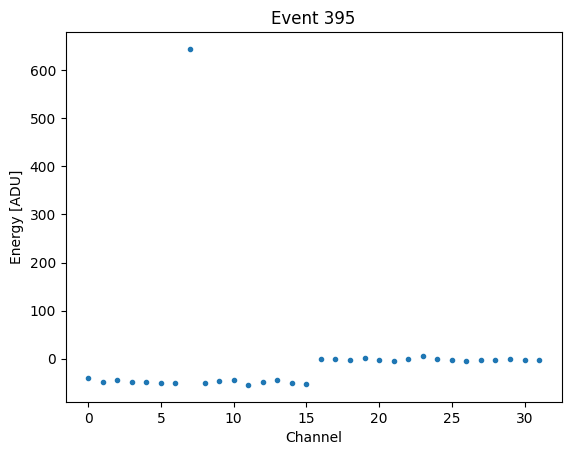

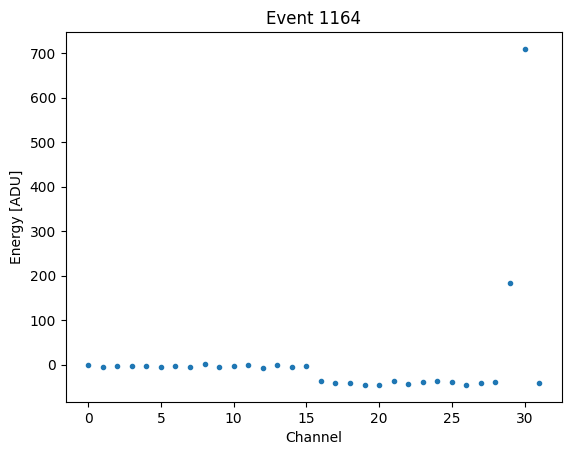

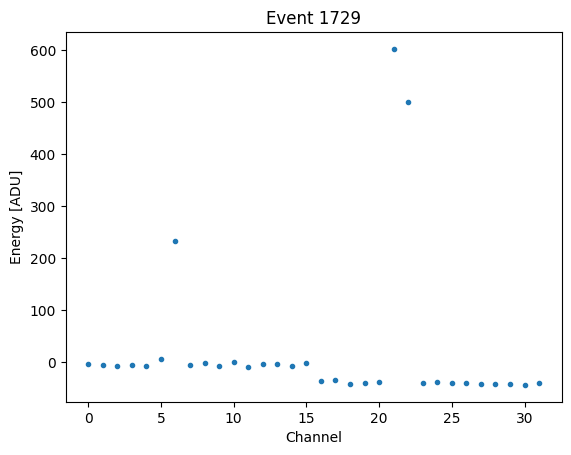

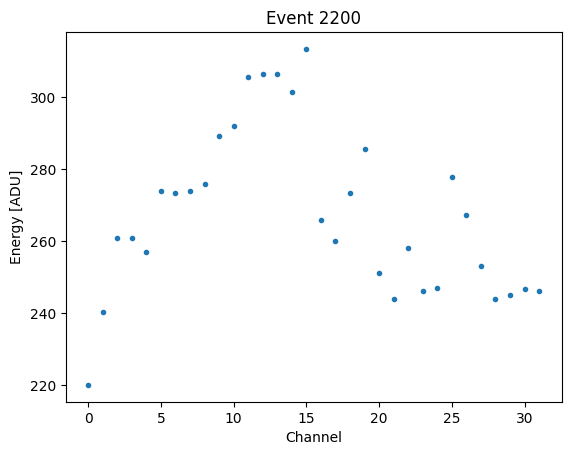

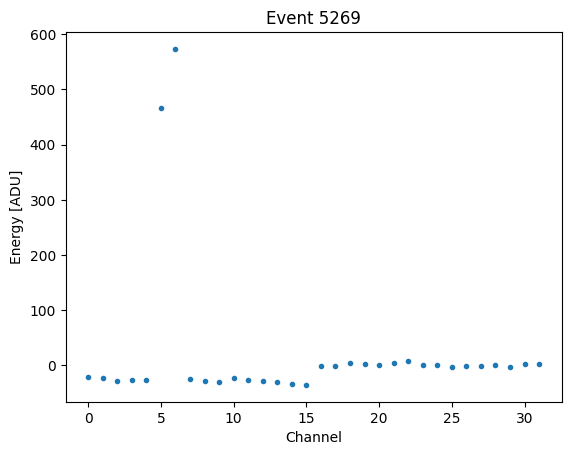

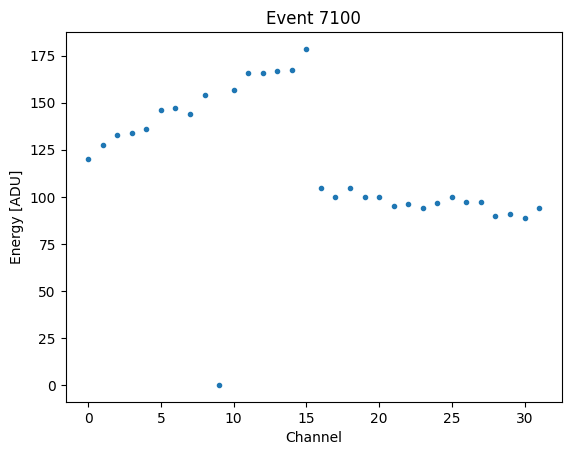

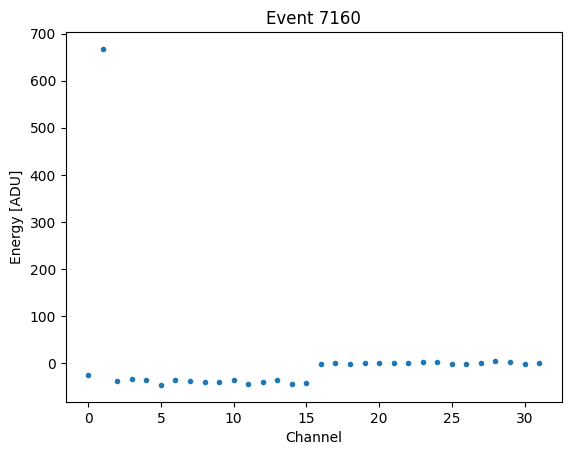

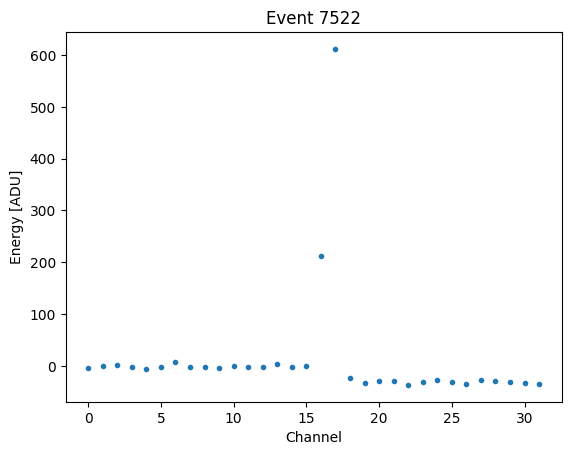

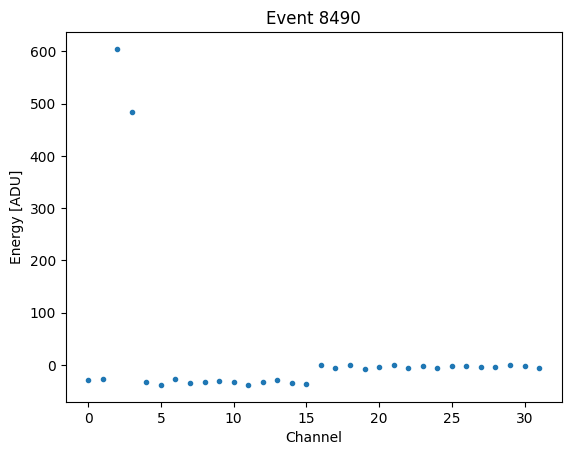

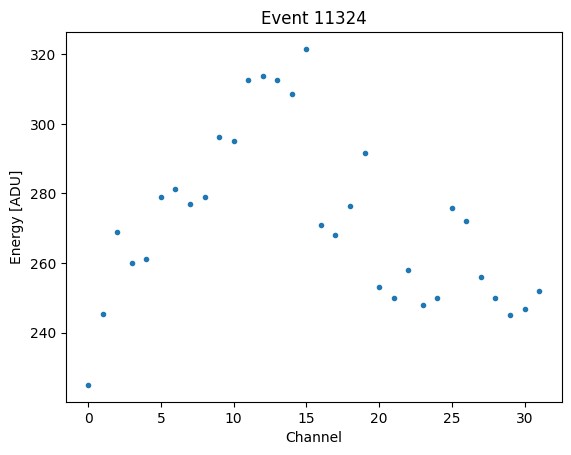

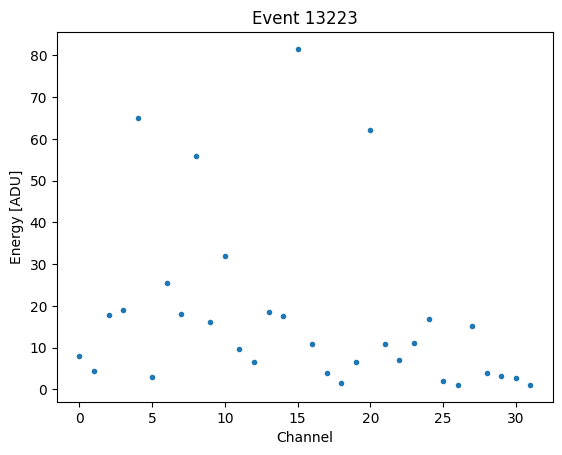

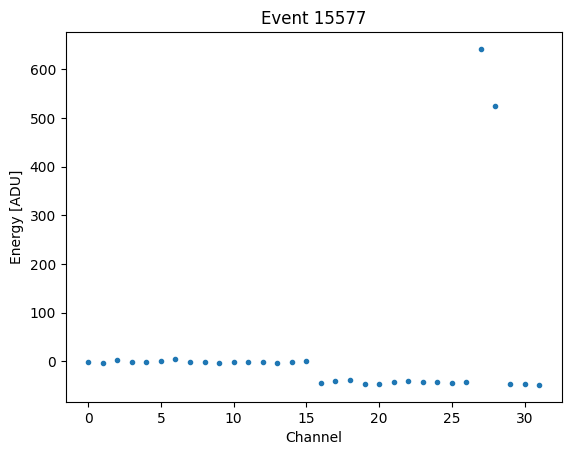

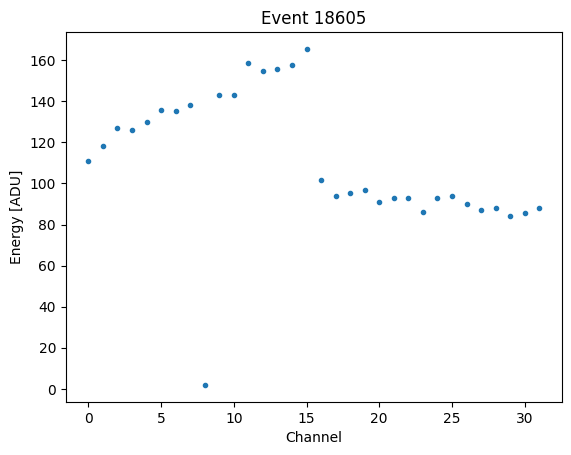

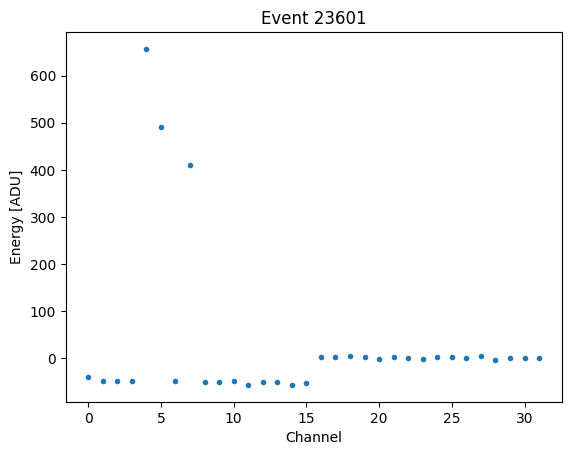

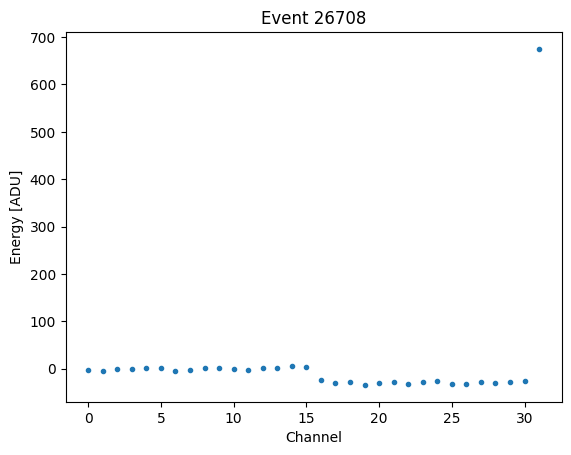

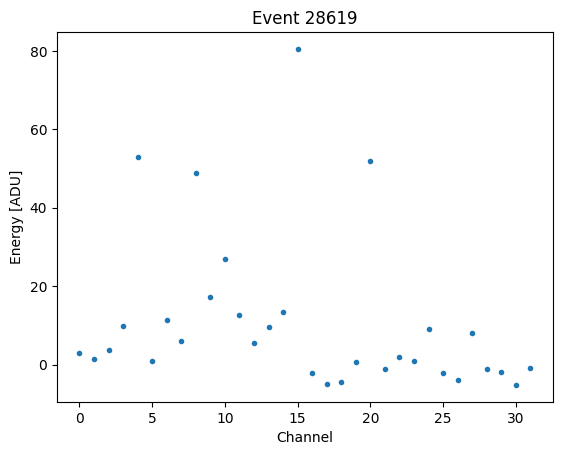

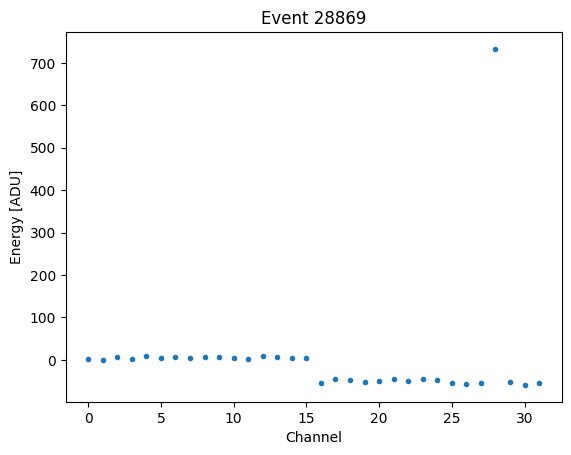

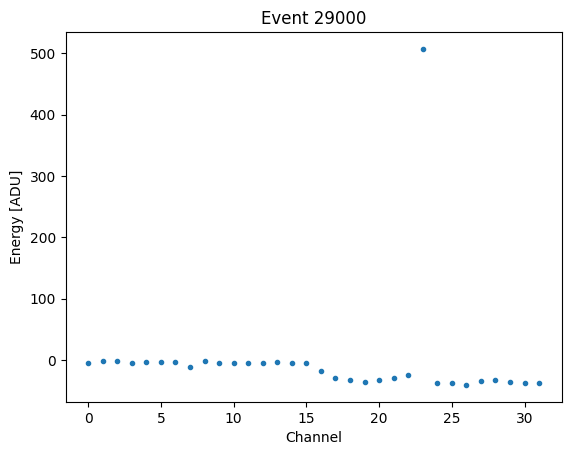

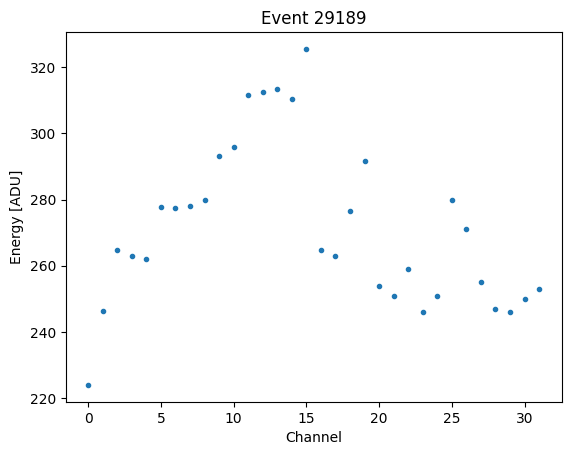

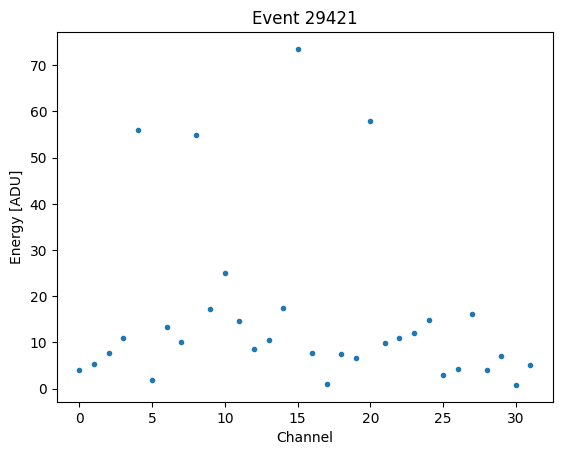

In [24]:
# Plot the first 20 bad events (pedestal subtracted data) to have a look at them

idx = (std >= std_val).nonzero()[0]
ev_bad = events[idx,:]-peds
for i in range(min(20, len(idx))):
    plt.plot(ev_bad[i,:],'.')
    plt.title('Event {}'.format(idx[i]))
    plt.xlabel('Channel')
    plt.ylabel('Energy [ADU]')
    plt.show()